# Exploring Country Credit Ratings

In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set visualization style & Display
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
sns.color_palette("mako")
pd.set_option('display.max_columns', None)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
 display: table-cell;
 text-align: center;
 vertical-align: middle;
}
</style>
""")

# I) Data Gathering & Cleaning

## 1.1 Define Useful Functions

In [3]:
#Function to clean the webscraped data 
def grades_cleaner(rating_classification, grades, index, category):
    """Function to clean the webscraped data from the second table in the Trading Economics
    html page, in order to extract the classes used in the classification model and associate them 
    to a letter grade"""
    
    temp_lst = []
    for i in grades[:index]:
        if i != category:
            temp_lst.append(i)
    rating_classification[category] = temp_lst
    grades = grades[index:]
    return rating_classification, grades

In [4]:
#Function to clean up World Bank Datasets
def clean_wbdf(df):
    """Function to clean all the datasets imported from the World Bank database in order to 
    reduce the time series csv to focus on the variable of interest"""
    
    variable_name = df['Indicator Name'][0] #Register Indicator Name for reference
    df = df[['Country Code', '2019']]#Focus on the columns on interest
    df = df.rename(columns = {'2019': variable_name}) #Rename 2019 column to indicator name
    df.set_index('Country Code', inplace = True)#Set index to Country Name to prepare df for concatenation
    return df

In [5]:
#Function to fill out null values with previous year values
def parse_fill_null(df, columns_list):
    """Function to parse through the World Bank datasets and fill out the missing values in the 
    column of interest by older data entries in the specified number of years"""
    
    for year in columns_list:
        for index, row in df.iterrows():
            if (pd.isnull(df.loc[index, '2019'])) and (pd.isnull(df.loc[index, year]) == False):
                df.loc[index, '2019'] = df.loc[index, year]   
    return df

In [374]:
def accuracy_comp(y_train, p_train, y_test, p_test):
     """This function compares the accuracy scores of train and test sets
     predictions"""
 
     train_accuracy = accuracy_score(y_train, p_train)
     test_accuracy = accuracy_score(y_test, p_test)
 
     print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
     print(f"Test Accuracy: {(test_accuracy * 100):.4}%")

## 1.2 Webscrape Base Data

### Country Credit Ratings Across

Source: Wikirating -- https://www.wikirating.org/wiki/List_of_countries_by_credit_rating

This page lists a comprehensive number of countries & sovereign territories and provides data for long-term foreign currency credit ratings for sovereign bons as reported by DBRS, Fitch, Moody's, Scope Ratings and Standard & Poor's, as compared to the Sovereign Wikirating Index.

In [6]:
#Retrieve html page & pass it to Beautiful Soup for parsing
wikirating_page = requests.get('https://www.wikirating.org/wiki/List_of_countries_by_credit_rating')
soup = BeautifulSoup(wikirating_page.content, 'html.parser')

In [7]:
#Select a container
table = soup.find('tbody')

In [8]:
#Extract the country & related ratings from the table
country_ratings = [a.find('a').string for a in table.findAll('td')]

In [9]:
#Clean Up country Ratings
#Create Empty lists to hold the variables
list_of_countries = []
swi = []
sp = []
scope = []
moody = []
fitch = []
dbrs = []

#Fill lists will all the relevant values
for i in range(0, len(country_ratings), 7):
    list_of_countries.append(country_ratings[i])
    swi.append(country_ratings[i+1])
    sp.append(country_ratings[i+2])
    scope.append(country_ratings[i+3])
    moody.append(country_ratings[i+4])
    fitch.append(country_ratings[i+5])
    dbrs.append(country_ratings[i+6])
    
#Compare the lengths of all lists to ensure they are consistent
print('Countries: ', len(list_of_countries), '\nSWI: ', len(swi), '\nS&P: ', len(sp), '\nScope: ', len(scope),
     '\nMoody\'s: ', len(moody), '\nFitch: ', len(fitch), '\nDBRS: ', len(dbrs))

Countries:  198 
SWI:  198 
S&P:  198 
Scope:  198 
Moody's:  198 
Fitch:  198 
DBRS:  198


In [10]:
#Create an empty dictionary to put the lists together
wiki_ratings = {}

i = 0
for country in list_of_countries:
    wiki_ratings[country] = {'Sovereign Wikirating Index': swi[i],
                              'Standard & Poor': sp[i],
                              'Scope': scope[i],
                              'Moody\'s': moody[i],
                              'Fitch': fitch[i],
                              'DBRS': dbrs[i]}
    i += 1

#Transform the dictionary to a DataFrame
wikidf = pd.DataFrame.from_dict(wiki_ratings, orient = 'index')
wikidf.head()

,Sovereign Wikirating Index,Standard & Poor,Scope,Moody's,Fitch,DBRS
Afghanistan,BB-,n.r.,n.r.,n.r.,n.r.,n.r.
Albania,BBB-,B+,n.r.,B1,n.r.,n.r.
Algeria,B+,n.r.,n.r.,n.r.,n.r.,n.r.
Andorra,n.r.,BBB,n.r.,n.r.,BBB+,n.r.
Angola,B,CCC+,n.r.,Caa1,CCC,n.r.


In [11]:
#Replace 'n.r.' with null values
wikidf = wikidf.replace('n.r.', np.nan)
wikidf.head()

,Sovereign Wikirating Index,Standard & Poor,Scope,Moody's,Fitch,DBRS
Afghanistan,BB-,NaN,NaN,NaN,NaN,NaN
Albania,BBB-,B+,NaN,B1,NaN,NaN
Algeria,B+,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,BBB,NaN,NaN,BBB+,NaN
Angola,B,CCC+,NaN,Caa1,CCC,NaN


### Country Credit Rating Categories

Source: Trading Economics -- https://tradingeconomics.com/country-list/rating

*Good source of credit rating data but the number of countries listed is more limited than Wikirating List of countries by credit rating, but provides useful categories for rating countries*

In [12]:
#Retrieve html page & pass it to Beautiful Soup for parsing
trading_economics_page = requests.get('https://tradingeconomics.com/country-list/rating')
soup = BeautifulSoup(trading_economics_page.content, 'html.parser')

#### 1. Get the Trading Economics credit ratings 

In [13]:
#Select a container
container = soup.find('table', class_= "table table-hover")

In [14]:
#Select the list of countries in the table
countries = [a.string for a in container.findAll('a')]

#Clean up the extracted text
countries = [country.replace('\r\n', '') for country in countries]
countries = [country.replace('  ','') for country in countries]
#Remove the extra empty space at the end of some of the leftover countries
for country in countries:
    if country[-1] == ' ':
        countries[countries.index(country)] = country[:-1]


#Verify length
print(len(countries))

154


In [15]:
#Extract the ratings from the table
ratings = [span.string for span in container.findAll('span')]

#Create empty lists for each credit rating
s_and_p = []
moodys = []
fitch = []
dbrs = []
te = []

#All 5 credit ratings were extracted in ratings
#Append to each rating list created as appropriate (by index)
for i in range(0, len(ratings), 5):
    s_and_p.append(ratings[i]) #Starts at index 0, every 5
    moodys.append(ratings[i+1]) #starts at index 1, every 5
    fitch.append(ratings[i+2]) #starts at index 2, every 5
    dbrs.append(ratings[i+3])#starts at index 3, every 5
    te.append(ratings[i+4]) #starts at index 4, every 5
    
#Compare lengths, all should be the same
print('Standard & Poor: ', len(s_and_p), '\nMoody\'s: ', len(moodys), '\nFitch: ', len(fitch), 
     '\nDBRS: ', len(dbrs), '\nTrading Economics: ', len(te))

Standard & Poor:  154 
Moody's:  154 
Fitch:  154 
DBRS:  154 
Trading Economics:  154


In [16]:
#Clean up the text in the ratings & convert the trading economics rating to integers
for i in range(len(countries)):
    #Standard & Poor
    s_and_p[i] = s_and_p[i].replace('\r\n', '')
    s_and_p[i] = s_and_p[i].replace(' ', '')
    s_and_p[i] = s_and_p[i].replace('\n', '')
    #Moody's
    moodys[i] = moodys[i].replace('\r\n', '')
    moodys[i] = moodys[i].replace(' ', '')
    moodys[i] = moodys[i].replace('\n', '')
    #Fitch
    fitch[i] = fitch[i].replace('\r\n', '')
    fitch[i] = fitch[i].replace('\n', '')
    fitch[i] = fitch[i].replace(' ', '')
    #DBRS
    dbrs[i] = dbrs[i].replace('\r\n', '')
    dbrs[i] = dbrs[i].replace('\n', '')
    dbrs[i] = dbrs[i].replace(' ', '')
    #Trading Economics
    if te[i] != None: 
        te[i] = int(te[i])

In [17]:
#Create an empty dictionary, to associate each country to each of its ratings
credit_ratings = {}

i = 0
for country in countries: 
    credit_ratings[country] = {'Standard & Poor': s_and_p[i],
                              'Moody\'s': moodys[i],
                              'Fitch': fitch[i],
                              'DBRS': dbrs[i],
                              'Trading Economics': te[i]}
    i += 1

In [18]:
#Create a credit rating DataFrame from the dictionary created & preview
ratings_df = pd.DataFrame.from_dict(credit_ratings, orient = 'index')
ratings_df.head()

,Standard & Poor,Moody's,Fitch,DBRS,Trading Economics
Albania,B+,B1,,,35.0
Andorra,BBB,,BBB+,,62.0
Angola,CCC+,Caa1,CCC,,21.0
Argentina,CCC+,Ca,CCC,CCC,15.0
Armenia,,Ba3,B+,,16.0


In [19]:
#Add the Trading Economics Series to wikidf
trading_economics = ratings_df['Trading Economics']
wikidf['Trading Economisc'] = trading_economics
wikidf.head()

,Sovereign Wikirating Index,Standard & Poor,Scope,Moody's,Fitch,DBRS,Trading Economisc
Afghanistan,BB-,NaN,NaN,NaN,NaN,NaN,NaN
Albania,BBB-,B+,NaN,B1,NaN,NaN,35.0
Algeria,B+,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,BBB,NaN,NaN,BBB+,NaN,62.0
Angola,B,CCC+,NaN,Caa1,CCC,NaN,21.0


#### 2. Get the Credit Rating Categories for classification

In [20]:
#Select the container relevant to the bottom table on the html page
container2 = soup.find('div', class_ = 'col-md-12')

In [21]:
#Register categories
rating_class = [rc.string for rc in container2.findAll('td', class_ = 9)]

#Clean up the 2 values that were missing
rating_class[4] = 'Non-investment grade speculative'
rating_class.insert(6, 'Substantial risks')
rating_class[-2] = 'In default with little prospect for recovery'

In [22]:
rating_class

['Prime',
 'High grade',
 'Upper medium grade',
 'Lower medium grade',
 'Non-investment grade speculative',
 'Highly speculative',
 'Substantial risks',
 'Extremely speculative',
 'In default with little prospect for recovery',
 'In default']

In [23]:
#Gather the letter ratings in a list grades
grades = [grade.string for grade in container2.findAll('td')]

#Create an empty Dictionnary with nested lists to associate grades to rating class
rating_classification = {}
    
#Create list of number of values in each categories
num_of_values = [6, 16, 16, 16, 16, 16, 6, 5, 13, 12]
#Add the relevant grades to each of the 9 category
index = 0
for category in rating_class:
    rating_classification, grades = grades_cleaner(rating_classification, grades, num_of_values[index], category)
    index += 1

In [24]:
#Create empty dictionary
country_rating_class = {}

#Create an empty list to store the rows with no values on credit ratings to remove from df
rows_to_remove = []

#Attribute each rating to a class
for country in wikidf.index:
    grade = wikidf.loc[wikidf.index == country, 'Sovereign Wikirating Index'].values[0] #Locate the SWI rating
    
    #Check if the grade value is null
    #If null, look for rating in other rankings (S&P or Moody's -- otherwise if SWI null, all others null)
    if pd.isnull(grade):
        if pd.isnull(wikidf.loc[wikidf.index == country, 'Standard & Poor'].values[0]) == False: #S&P
            grade = wikidf.loc[wikidf.index == country, 'Standard & Poor'].values[0]
        elif pd.isnull(wikidf.loc[wikidf.index == country, 'Moody\'s'].values[0]) == False:
            grade = wikidf.loc[wikidf.index == country, 'Moody\'s'].values[0]
        else:
            rows_to_remove.append(country)
    
    #Fill in the country_rating_class dictionary
    for key in rating_classification:
        if grade in rating_classification[key]:
            country_rating_class[country] = key       

In [25]:
credit_rating = pd.Series(data = country_rating_class)
wikidf['Credit Rating'] = credit_rating
wikidf.head()

,Sovereign Wikirating Index,Standard & Poor,Scope,Moody's,Fitch,DBRS,Trading Economisc,Credit Rating
Afghanistan,BB-,NaN,NaN,NaN,NaN,NaN,NaN,Non-investment grade speculative
Albania,BBB-,B+,NaN,B1,NaN,NaN,35.0,Lower medium grade
Algeria,B+,NaN,NaN,NaN,NaN,NaN,NaN,Highly speculative
Andorra,NaN,BBB,NaN,NaN,BBB+,NaN,62.0,Lower medium grade
Angola,B,CCC+,NaN,Caa1,CCC,NaN,21.0,Highly speculative


In [26]:
wikidf.loc[wikidf['Credit Rating'].isna() == True]

,Sovereign Wikirating Index,Standard & Poor,Scope,Moody's,Fitch,DBRS,Trading Economisc,Credit Rating
Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
North Korea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marshall Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monaco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nauru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Palau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saint Kitts and Nevis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Syria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tuvalu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holy See,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ISO3 Country Codes

Source: United Nations Trade Statistics <https://unstats.un.org/unsd/tradekb/knowledgebase/country-code>

In [27]:
#Retrieve html page & pass it to Beautiful Soup for parsing
country_code_page = requests.get('https://unstats.un.org/unsd/tradekb/knowledgebase/country-code')
soup = BeautifulSoup(country_code_page.content, 'html.parser')

In [28]:
#Select container
container = soup.find('div', class_ = 'row article margin-top')

In [29]:
#Extract the text
iso3 = container.get_text()

#Clean-up 
iso3 = iso3.split('\r\n') #Split the extracted string/text
iso3 = iso3[2:] #Remove the first two sentences that were extarcted with the text
iso3[-1] = iso3[-1].replace('\n\n\n', '') #remove the trip '\n' characters from the last en

#Create a dictionary to store the iso3 values & country name combinations
iso3_codes = {}
for combination in iso3:
    iso3_codes[combination[4:-1]] = combination[:3]

In [30]:
#Transform dictionary into DataFrame
iso3_df = pd.DataFrame.from_dict(iso3_codes, orient = 'index', columns = ['Country Code'])
iso3_df.head(2)

,Country Code
Aruba,ABW
Afghanistan,AFG


In [31]:
#Append the Credit Rating to the iso3_df to create a base DataFrame
basedf = wikidf.drop(['Sovereign Wikirating Index', 'Standard & Poor', 'Scope', 'Moody\'s', 
                     'Fitch', 'DBRS', 'Trading Economisc'], axis = 1)
basedf['Country Code'] = iso3_df['Country Code']

In [32]:
#Preview DataFrame
display(basedf.info())
basedf.head()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, Afghanistan to Zimbabwe
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Credit Rating  188 non-null    object
 1   Country Code   173 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


None

,Credit Rating,Country Code
Afghanistan,Non-investment grade speculative,AFG
Albania,Lower medium grade,ALB
Algeria,Highly speculative,DZA
Andorra,Lower medium grade,AND
Angola,Highly speculative,AGO


In [33]:
#Create a list of missing country codes for future reference (when putting all the imported df together)
missing_iso3 = list(basedf.loc[basedf['Country Code'].isna() == True].index)
missing_iso3

['Bolivia',
 'Brunei',
 "People's Republic of China",
 'Ivory Coast',
 'Democratic Republic of the Congo',
 'Republic of the Congo',
 'Eswatini',
 'Iran',
 'North Korea',
 'South Korea',
 'Kosovo',
 'Laos',
 'Libya',
 'Macau',
 'Federated States of Micronesia',
 'Moldova',
 'North Macedonia',
 'Russia',
 'South Sudan',
 'Syria',
 'Taiwan',
 'Tanzania',
 'Holy See',
 'Venezuela',
 'Vietnam']

## 1.3 Import Datasets

#### World Bank Datasets Metadata by Country -- Income Group, Country Names, Country Codes & Region

In [170]:
income_group = pd.read_csv('Data/Metadata_Country_API_SP.ADO.TFRT_DS2_en_csv_v2_2449186.csv')

#Clean dataframe
income_group = income_group[['Country Code', 'Region', 'IncomeGroup', 'TableName']] #Select columns of interest
income_group.rename(columns = {'IncomeGroup': 'Income Group', 'TableName' : 'Country Name'}, inplace = True)
income_group.set_index('Country Code', inplace = True) #Set 'Country Code' as index

#remove rows that are not countries (e.g. regions or reference)
rows_to_drop = list(income_group.loc[income_group['Income Group'].isna() == True].index)
income_group = income_group.drop(rows_to_drop)

In [171]:
income_group.head()

,Region,Income Group,Country Name
Country Code,,,
ABW,Latin America & Caribbean,High income,Aruba
AFG,South Asia,Low income,Afghanistan
AGO,Sub-Saharan Africa,Lower middle income,Angola
ALB,Europe & Central Asia,Upper middle income,Albania
AND,Europe & Central Asia,High income,Andorra


In [172]:
#Use the country codes to fill out the missing ISO3 previously recorded
for country in income_group['Country Name'].values:
    if country in missing_iso3:
        iso3 = income_group.loc[income_group['Country Name'] == country, 'Country Name'].index[0]
        basedf['Country Code'][country] = iso3
        missing_iso3.remove(country)
        
#Check for the remainder, on the chance the the Country Name is written differently
for country in missing_iso3:
    for name in income_group['Country Name']:
        if country in name:
            iso3 = income_group.loc[income_group['Country Name'] == name].index[0]
            basedf['Country Code'][country] = iso3
            missing_iso3.remove(country)

KeyError: 'Country Code'

In [173]:
missing_iso3

["People's Republic of China",
 'Ivory Coast',
 'Democratic Republic of the Congo',
 'Republic of the Congo',
 'North Korea',
 'South Korea',
 'Laos',
 'Macau',
 'Federated States of Micronesia',
 'Syria',
 'Taiwan',
 'Holy See']

In [174]:
#Fill in the remaining missing country codes 
iso3_lst = ['CHN', 'CIV', 'COD', 'COG', 'PRK', 'KOR', 'LAO', 'MAC', 'FSM', 'SYR', 'TWN', 'VAT']

i = 0
for country in missing_iso3:
    basedf['Country Code'][country] = iso3_lst[i]
    i += 1

KeyError: 'Country Code'

In [175]:
#Verify the information base dataframe
display(basedf.info())

#Set Country Codes as index
basedf = basedf.reset_index()
basedf.rename(columns = {'index': 'Country Name'}, inplace = True)
basedf = basedf.set_index('Country Code')

#Preview
basedf.head()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, AFG to ZWE
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   198 non-null    object
 1   Credit Rating  188 non-null    object
dtypes: object(2)
memory usage: 14.6+ KB


None

,Country Name,Credit Rating
Country Code,,
AFG,Afghanistan,Non-investment grade speculative
ALB,Albania,Lower medium grade
DZA,Algeria,Highly speculative
AND,Andorra,Lower medium grade
AGO,Angola,Highly speculative


In [176]:
#Drop 'Country Name' from income_group to avoid duplication in final df
income_group = income_group.drop('Country Name', axis = 1)
income_group.head()

,Region,Income Group
Country Code,,
ABW,Latin America & Caribbean,High income
AFG,South Asia,Low income
AGO,Sub-Saharan Africa,Lower middle income
ALB,Europe & Central Asia,Upper middle income
AND,Europe & Central Asia,High income


#### Adjusted Net National Income

In [177]:
adj_net_national_income = pd.read_csv('Data/Adjusted Net national Income.csv', header = 2)
adj_net_national_income = parse_fill_null(adj_net_national_income, ['2018'])
adj_net_national_income = clean_wbdf(adj_net_national_income)

#### Adolescent Fertility Rate (Births per 1,000 Women Aged Between 15 - 19)

In [178]:
fertility_rate_15_19 = pd.read_csv('Data/Adolescent Fertility Rate (Births per 1,000 Women Ages 15-19).csv', header = 2)
fertility_rate_15_19 = clean_wbdf(fertility_rate_15_19)

#### Battle Related Deaths (Number of People)

In [179]:
battle_deaths = pd.read_csv('Data/Battle-related Deaths (Number of People).csv', header = 2)
battle_deaths = clean_wbdf(battle_deaths)

#Cross with the webscraped wiki page on current conflict

#### Birth Rate, Crude (per 1,000 people)

In [180]:
birth_rate = pd.read_csv('Data/Birth Rate, Crude (per 1,000 people).csv', header = 2)
birth_rate = parse_fill_null(birth_rate, ['2018', '2017'])
birth_rate = clean_wbdf(birth_rate)

#### Compulsory Education, Duration in Years

In [181]:
comp_education = pd.read_csv('Data/Compulsory Education, Duration (years).csv', header = 2)
comp_education = clean_wbdf(comp_education)

#### Consumer Price Index

In [182]:
cpi = pd.read_csv('Data/Consumer Price Index.csv', header = 2)
cpi = parse_fill_null(cpi, ['2018', '2017', '2016'])
cpi = clean_wbdf(cpi)

#### Corporate Tax Rate

In [183]:
#Corporate Tax Rate
corp_tax_rate = pd.read_excel('Data/2020-Corporate-Tax-Rates-Around-the-World.csv.xlsx')

#clean up
corp_tax_rate.rename(columns = {'iso_3' : 'Country Code', 'country': 'Country Name', 'rate': 'Corporate Tax Rate'}, 
                     inplace = True)
corp_tax_rate.set_index('Country Code', inplace = True)

#Focus on columns on interest
corp_tax_rate = corp_tax_rate[['Corporate Tax Rate']]

#### Corruption Perception Index & Significant Changes in CI

In [184]:
#Corruption Perception Index
corruption_index = pd.read_csv('Data/CPI2020_GlobalTablesTS_210125.csv', encoding = 'latin-1', header = 2)

#Drop columns where the majority of entries are null
corruption_index.drop(['Country', 'Standard error', 'Region', 'Number of sources','African Development Bank CPIA', 
                       'Bertelsmann Foundation Transformation Index', 
                       'Bertelsmann Foundation Sustainable Governance Index', 'Freedom House Nations in Transit',
                       'IMD World Competitiveness Yearbook', 'PERC Asia Risk Guide','World Bank CPIA',
                      'Economist Intelligence Unit Country Ratings', 'World Justice Project Rule of Law Index',
                      'World Economic Forum EOS', 'PRS International Country Risk Guide'], 
                      axis = 1,  inplace = True)
corruption_index.set_index('ISO3', inplace = True) #Set index to country codes (i.e. 'ISO3')
corruption_index.rename(columns = {'CPI score 2020' : 'CPI 2020', 'Rank' : 'CPI rank 2020',
                                  'Lower CI' : 'CI Lower', 'Upper CI' : 'CI Upper'}, inplace = True)


#CPI Significant Changes
corruption_sig_changes = pd.read_csv('Data/CPI2020_SignificantChanges_210125.csv', header = 2)

#Clean up corryption_sig_changes & prepare to add to final df
columns = list(corruption_sig_changes.columns[:11])#Select empty columns
corruption_sig_changes = corruption_sig_changes[columns] #Remove empty columns
corruption_sig_changes.drop(['Country', 'Region', 'CPI 2020', 'CPI rank 2020', 'Standard error 2020', 
                            'Standard error 2019'], axis = 1, inplace = True)
corruption_sig_changes.set_index('ISO3', inplace = True)

#### Current Account Balance (BoP, current USD)

In [185]:
current_acc_balance = pd.read_csv('Data/Current Account Balance (BoP).csv', header = 2)
current_acc_balance = parse_fill_null(current_acc_balance, ['2018', '2017', '2016'])
current_acc_balance = clean_wbdf(current_acc_balance)

#### Death Rate, Crude (per 1,000 people)

In [186]:
death_rate = pd.read_csv('Data/Death Rate, Crude (per 1,000 people).csv', header = 2)
death_rate = parse_fill_null(death_rate, ['2018', '2017', '2016'])
death_rate = clean_wbdf(death_rate)

#Consider engineering a variable on rising or falling death rate over the past xx years

#### Debt to GDP Ration

In [187]:
debt_to_gdp_ratio = pd.read_csv('Data/Debt to GDP Ratio 2021.csv')
debt_to_gdp_ratio.set_index('country', inplace = True)

#### Ease of Doing Business Index ( 1 = most business-friendlt regulations)

In [188]:
ease_of_doing_business = pd.read_csv('Data/Ease of Doing Business Index.csv', header = 2)
ease_of_doing_business = clean_wbdf(ease_of_doing_business)

#### Exports of Goods and Services (% GDP)

In [189]:
exports_goods_and_services = pd.read_csv('Data/Export of Goods and Services (% GDP).csv', header = 2)
exports_goods_and_services = parse_fill_null(exports_goods_and_services, ['2018', '2017', '2016', '2015'])
exports_goods_and_services = clean_wbdf(exports_goods_and_services)

#### Fertility Rate, Total (Births Per Woman)

In [190]:
fertility = pd.read_csv('Data/Fertility Rate, Total (birth per woman).csv', header = 2)
fertility = clean_wbdf(fertility)

#### Foreign Direct Investment Net Inflows (BoP, current USD)

In [191]:
fdi_inflows_bop = pd.read_csv('Data/Foreign Direct Investment Net Inflows (BoP Constant).csv', header = 2)
fdi_inflows_bop = parse_fill_null(fdi_inflows_bop, ['2018'])
fdi_inflows_bop = clean_wbdf(fdi_inflows_bop)

#Feature Engineer Trends of FDI inflows

#### Foreign Direct Investment Net Outflows (BoP, current USD)

In [192]:
fdi_outflows_bop = pd.read_csv('Data/Foreign Direct Investment Net Outflows.csv', header = 2)
fdi_outflows_bop = parse_fill_null(fdi_outflows_bop, ['2018'])
fdi_outflows_bop = clean_wbdf(fdi_outflows_bop)


#Feature engineer trend for FDI outflows

#### Foreign Direct Investment Net Inflows (% GDP)

In [193]:
fdi_inflows = pd.read_csv('Data/Foreign Direct Investment Net Inflows (% GDP).csv', header = 2)
fdi_inflows = parse_fill_null(fdi_inflows, ['2018', '2017'])
fdi_inflows = clean_wbdf(fdi_inflows)

#### Foreign Direct Investment Net Outflows (% GDP)

In [194]:
fdi_outflows = pd.read_csv('Data/Foreign Direct Investment, Net Outflows (% GDP).csv', header = 2)
fdi_outflows = parse_fill_null(fdi_outflows, ['2018'])
fdi_outflows = clean_wbdf(fdi_outflows)

#### Gross Domestic Product

In [195]:
#Gross Domestic Product
gdp = pd.read_csv('Data/GDP.csv', header = 4)
#Name the columns
gdp.columns = ['Country Code', 'Ranking', 'Unnamed: 1', 'Economy', 'GDP (million of US dollars)', 'Unnamed: 2']
gdp = gdp.drop(['Ranking', 'Unnamed: 1', 'Economy', 'Unnamed: 2'], axis = 1) #Drop uninteresting columns
gdp = gdp.iloc[:217] #Drop Unnecessary Rows (e.g. empty rows, rows containing regional & World estimates)
gdp.set_index('Country Code', inplace = True) #Set country code as index

In [196]:
gdp.head()

,GDP (million of US dollars)
Country Code,
USA,"21,433,226"
CHN,"14,342,903"
JPN,"5,081,770"
DEU,"3,861,124"
IND,"2,868,929"


In [197]:
#Clean up gdp df to cast values as floats
gdp_clean_up = gdp['GDP (million of US dollars)'].to_dict() #Convert to dict

#Remove extra characters and convert to float
for key in gdp_clean_up:
    value = gdp_clean_up[key]
    if type(value) != float:
        value = value.replace(' ', '')
        value = value.replace(',', '')
        if '-' in value:
            value = np.nan
        gdp_clean_up[key] = float(value)
        
gdp = pd.DataFrame.from_dict(gdp_clean_up, orient = 'index', columns = ['GDP (million of US dollars)'])
gdp.head()

,GDP (million of US dollars)
USA,21433226.0
CHN,14342903.0
JPN,5081770.0
DEU,3861124.0
IND,2868929.0


#### Gross Domestic Product (Constant 2010 USD)

In [198]:
gdp_constant = pd.read_csv('Data/GDP Constant 2010.csv', header = 2)
gdp_constant = parse_fill_null(gdp_constant, ['2017', '2018'])
gdp_constant = clean_wbdf(gdp_constant)

#### Gross Domestic Product per Capita (Constant 2010 USD)

In [199]:
gdp_per_capita = pd.read_csv('Data/GDP per Capita (Constant USD 2010).csv', header = 2)
gdp_per_capita = parse_fill_null(gdp_per_capita, ['2018', '2017', '2016', '2015', '2015', '2014', '2011', '2010'])
gdp_per_capita = clean_wbdf(gdp_per_capita)

#### Life Expectancy at Birth, Female (years)

In [200]:
female_life_expectancy = pd.read_csv('Data/Life Expectancy at Birth, Female (years).csv', header = 2)
female_life_expectancy = clean_wbdf(female_life_expectancy)

#### Life Expectancy at Birth, Male (years)

In [201]:
male_life_expectancy = pd.read_csv('Data/Life Expectancy at Birth, Male (years).csv', header = 2)
male_life_expectancy = clean_wbdf(male_life_expectancy)

#### Lifetime Risk of Maternal Death (%)

In [202]:
maternal_death_risk = pd.read_csv('Data/Lifetime Risk of Maternal Death (%).csv', header = 2)
maternal_death_risk = parse_fill_null(maternal_death_risk, ['2017'])
maternal_death_risk = clean_wbdf(maternal_death_risk)

#### Literacy Rate

In [203]:
literacy_rate = pd.read_csv('Data/Literacy Rate.csv')
literacy_rate.rename(columns = {'country' : 'Country Name', 'literacyRate' : 'Literacy Rate'},
                    inplace = True) #rename columns
literacy_rate = literacy_rate[['Country Name', 'Literacy Rate']] #select columns of interest
literacy_rate.set_index('Country Name', inplace = True)

#Country code not available so need to concat with Country Name

In [204]:
literacy_rate

,Literacy Rate
Country Name,
Greenland,100.0
Andorra,100.0
North Korea,100.0
Uzbekistan,100.0
San Marino,99.9
...,...
Mali,35.5
South Sudan,34.5
Guinea,30.4


#### Median Income

In [205]:
median_income = pd.read_csv('Data/Median Income.csv')
median_income.rename(columns = {'country': 'Country Name', 'medianHouseholdIncome': 'Median Household Income',
                               'medianPerCapitaIncome': 'Median Per Capita Income', 'medianAnnualIncome' : 
                               'Median Annual Income'}, inplace = True)
median_income.set_index('Country Name', inplace = True)

#Save population information to cross against the total population dataset for latest data
population2021 = median_income['pop2021']

median_income.drop('pop2021', axis = 1, inplace = True)

#Country code not available so need to concat with Country Name

#### Number of Deaths Aged 5 - 9

In [206]:
deaths_5_9 = pd.read_csv('Data/Number of Deaths Ages 5-9 Years.csv', header = 2)
deaths_5_9 = clean_wbdf(deaths_5_9)

#### Number of Deaths Aged 10 - 14

In [207]:
deaths_10_14 = pd.read_csv('Data/Number of Deaths Ages 10-14.csv', header = 2)
deaths_10_14 = clean_wbdf(deaths_10_14)

#### Number of Deaths Aged 15 - 19

In [208]:
deaths_15_19 = pd.read_csv('Data/Number of Deaths Ages 15-19 Years.csv', header = 2)
deaths_15_19 = clean_wbdf(deaths_15_19)

#### Number of Deaths Aged 20 - 24

In [209]:
deaths_20_24 = pd.read_csv('Data/Number of Deaths Ages 20-24 Years.csv', header = 2)
deaths_20_24 = clean_wbdf(deaths_20_24)

#### Population Growth Annual Percentage

In [210]:
pop_growth = pd.read_csv('Data/Population Growth (annual %).csv', header = 2)
pop_growth = clean_wbdf(pop_growth)


#Add column on growth trend (looking at the average growth rate since 1960)

#### Population Total

In [211]:
pop_total = pd.read_csv('Data/Population Total.csv', header = 2)
pop_total = clean_wbdf(pop_total)

#### Surface Area

In [212]:
surface_area = pd.read_csv('Data/Surface Area (sq. km).csv', header = 2)
surface_area = parse_fill_null(surface_area, ['2018', '2017'])
surface_area = clean_wbdf(surface_area)

#### Unemployed, male (% of male labor force) (International Labour Organization estimates))

In [213]:
male_unemployment = pd.read_csv('Data/Unemployed, male (% of male labor force) (modeled ILO estimate).csv', header = 2)
male_unemployment = clean_wbdf(male_unemployment)

#### Unemployed, female (% of female labor force) (International Labour Organization Estimates)

In [214]:
female_unemployment = pd.read_csv('Data/Unemployment, female (% of female labor force) (modeled ILO estimate).csv', 
                                  header = 2)
female_unemployment = clean_wbdf(female_unemployment)

#### Unemployment, Total (% of total labour force) (modeled ILO estimates)

In [215]:
unemployment = pd.read_csv('Data/Unemployment, total (% of total labor force) (modeled ILO estimate).csv',
                          header = 2)
unemployment = clean_wbdf(unemployment)

#### Urban Population Growth (Annual %)

In [216]:
urban_pop_growth = pd.read_csv('Data/Urban population growth (annual %).csv', header = 2)
urban_pop_growth = clean_wbdf(urban_pop_growth)

## 1.4 Create Workable Dataframe

In [217]:
#list of dataframes to concat
to_concat = [income_group, adj_net_national_income, fertility_rate_15_19, battle_deaths, birth_rate, comp_education, cpi, 
            corp_tax_rate, gdp, gdp_constant, gdp_per_capita, death_rate, ease_of_doing_business, 
            exports_goods_and_services, fertility, fdi_inflows, fdi_outflows, fdi_inflows_bop, fdi_outflows_bop, 
            female_life_expectancy, male_life_expectancy, maternal_death_risk, deaths_5_9, deaths_10_14, deaths_15_19,
            deaths_20_24, pop_growth, pop_total, surface_area, corruption_index, corruption_sig_changes, unemployment, 
            male_unemployment, female_unemployment, urban_pop_growth]
df = pd.concat(to_concat, axis = 1, sort = True)

In [218]:
df.head()

,Region,Income Group,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)","Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,GDP (million of US dollars),GDP (constant 2010 US$),GDP per capita (constant 2010 US$),"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (BoP, current US$)","Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 5-9 years,Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Population growth (annual %),"Population, total",Surface area (sq. km),CPI 2020,CPI rank 2020,CI Lower,CI Upper,Global Insight Country Risk Ratings,Varieties of Democracy Project,CPI 2019,Change in scores 2019-2020,CPI rank 2019,Change in rank 2019-2020,"Unemployment, total (% of total labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, female (% of female labor force) (modeled ILO estimate)",Urban population growth (annual %)
ABW,Latin America & Caribbean,High income,NaN,19.6732,NaN,11.756,13.0,109.534355,25.0,3056.0,2.805918e+09,26630.205281,9.205,NaN,73.332115,1.901,5.315477,NaN,-7.604174e+07,5.981797e+07,78.641,73.768,NaN,NaN,NaN,NaN,NaN,0.442122,106314.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.752364
AFG,South Asia,Low income,1.864930e+10,61.3250,29940.0,31.802,9.0,149.895975,20.0,19291.0,2.180886e+10,573.287551,6.285,173.0,NaN,4.321,0.121323,0.136441,2.340455e+07,2.632105e+07,66.388,63.382,3.063593,2584.0,1961.0,12368.0,13461.0,2.311817,38041754.0,652860.0,19.0,165.0,15.0,23.0,10.0,26.0,16.0,3.0,173.0,-8.0,10.98,10.19,13.81,3.322572
AGO,Sub-Saharan Africa,Lower middle income,5.411314e+10,145.3900,25.0,40.232,6.0,378.883721,30.0,88816.0,9.901351e+10,3111.157699,7.981,177.0,40.556871,5.442,-4.614588,-2.645282,-4.098479e+09,-2.349426e+09,64.039,58.416,1.451251,10336.0,5208.0,8736.0,10939.0,3.242983,31825295.0,1246700.0,27.0,142.0,23.7,30.3,22.0,31.0,26.0,1.0,146.0,-4.0,6.93,6.63,7.22,4.249894
AIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
#Sort column in alphabetical order
df = df.sort_index(axis = 1)

In [220]:
#Preview DataFrameInformation
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 279 entries, ABW to ZWE
Data columns (total 44 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Adjusted net national income (current US$)                             219 non-null    float64
 1   Adolescent fertility rate (births per 1,000 women ages 15-19)          240 non-null    float64
 2   Battle-related deaths (number of people)                               49 non-null     float64
 3   Birth rate, crude (per 1,000 people)                                   254 non-null    float64
 4   CI Lower                                                               180 non-null    float64
 5   CI Upper                                                               180 non-null    float64
 6   CPI 2019                                                               180 non-null    float6

None

,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
ABW,NaN,19.6732,NaN,11.756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,109.534355,25.0,9.205,NaN,73.332115,1.901,5.315477,-7.604174e+07,NaN,5.981797e+07,2.805918e+09,3056.0,26630.205281,NaN,High income,78.641,73.768,NaN,NaN,NaN,NaN,NaN,0.442122,106314.0,Latin America & Caribbean,180.0,NaN,NaN,NaN,0.752364,NaN
AFG,1.864930e+10,61.3250,29940.0,31.802,15.0,23.0,16.0,19.0,173.0,165.0,-8.0,3.0,9.0,149.895975,20.0,6.285,173.0,NaN,4.321,0.121323,2.340455e+07,0.136441,2.632105e+07,2.180886e+10,19291.0,573.287551,10.0,Low income,66.388,63.382,3.063593,1961.0,12368.0,13461.0,2584.0,2.311817,38041754.0,South Asia,652860.0,13.81,10.19,10.98,3.322572,26.0
AGO,5.411314e+10,145.3900,25.0,40.232,23.7,30.3,26.0,27.0,146.0,142.0,-4.0,1.0,6.0,378.883721,30.0,7.981,177.0,40.556871,5.442,-4.614588,-4.098479e+09,-2.645282,-2.349426e+09,9.901351e+10,88816.0,3111.157699,22.0,Lower middle income,64.039,58.416,1.451251,5208.0,8736.0,10939.0,10336.0,3.242983,31825295.0,Sub-Saharan Africa,1246700.0,7.22,6.63,6.93,4.249894,31.0
AIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
#Combine the multiple feature df with the base dataframe
finaldf = pd.concat([basedf, df], axis = 1, sort = True)

In [222]:
#Remove all the extra rows (e.g. regional data) that do not have a Credit Rating as part of the base dataframe
finaldf = finaldf.loc[finaldf['Credit Rating'].isna() == False]

In [223]:
#Preview final Dataframe
display(finaldf.info())
display(finaldf.head())

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, AFG to ZWE
Data columns (total 46 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Country Name                                                           188 non-null    object 
 1   Credit Rating                                                          188 non-null    object 
 2   Adjusted net national income (current US$)                             174 non-null    float64
 3   Adolescent fertility rate (births per 1,000 women ages 15-19)          182 non-null    float64
 4   Battle-related deaths (number of people)                               36 non-null     float64
 5   Birth rate, crude (per 1,000 people)                                   187 non-null    float64
 6   CI Lower                                                               177 non-null    float6

None

,Country Name,Credit Rating,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
AFG,Afghanistan,Non-investment grade speculative,1.864930e+10,61.3250,29940.0,31.802,15.00,23.00,16.0,19.0,173.0,165.0,-8.0,3.0,9.0,149.895975,20.0,6.285,173.0,NaN,4.321,0.121323,2.340455e+07,0.136441,2.632105e+07,2.180886e+10,19291.0,573.287551,10.0,Low income,66.388,63.382,3.063593,1961.0,12368.0,13461.0,2584.0,2.311817,38041754.0,South Asia,652860.0,13.81,10.19,10.98,3.322572,26.0
AGO,Angola,Highly speculative,5.411314e+10,145.3900,25.0,40.232,23.70,30.30,26.0,27.0,146.0,142.0,-4.0,1.0,6.0,378.883721,30.0,7.981,177.0,40.556871,5.442,-4.614588,-4.098479e+09,-2.645282,-2.349426e+09,9.901351e+10,88816.0,3111.157699,22.0,Lower middle income,64.039,58.416,1.451251,5208.0,8736.0,10939.0,10336.0,3.242983,31825295.0,Sub-Saharan Africa,1246700.0,7.22,6.63,6.93,4.249894,31.0
ALB,Albania,Lower medium grade,1.232864e+10,19.5028,NaN,11.620,34.50,37.50,35.0,36.0,106.0,104.0,-2.0,1.0,9.0,119.049258,15.0,8.082,82.0,31.555552,1.597,7.860513,1.201022e+09,0.261643,3.997687e+07,1.487230e+10,15279.0,5210.688290,35.0,Upper middle income,80.201,77.002,0.026286,35.0,70.0,86.0,31.0,-0.426007,2854191.0,Europe & Central Asia,28750.0,11.31,11.58,11.47,1.071414,32.0
AND,Andorra,Lower medium grade,NaN,NaN,NaN,7.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,10.0,3.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.539838e+09,3154.0,45887.302126,NaN,High income,NaN,NaN,NaN,0.0,1.0,2.0,0.0,0.176454,77142.0,Europe & Central Asia,470.0,NaN,NaN,NaN,0.088439,NaN
ARE,United Arab Emirates,High grade,3.840381e+11,5.2276,NaN,10.223,65.71,76.29,71.0,71.0,21.0,21.0,0.0,0.0,6.0,114.524661,0.0,1.521,16.0,92.456253,1.387,3.273826,1.378747e+10,3.775711,1.590111e+10,4.047000e+11,421142.0,41420.483032,47.0,High income,79.314,77.291,0.005602,85.0,188.0,426.0,93.0,1.438780,9770529.0,Middle East & North Africa,98647.9,6.33,1.42,2.28,1.746897,72.0


# II) Cleaning Data & Preparing for Modeling

### Dealing with Null Values

In [244]:
finaldf.isna().sum()

Country Name                                                               0
Credit Rating                                                              0
Adjusted net national income (current US$)                                14
Adolescent fertility rate (births per 1,000 women ages 15-19)              6
Battle-related deaths (number of people)                                 152
Birth rate, crude (per 1,000 people)                                       1
CI Lower                                                                  11
CI Upper                                                                  11
CPI 2019                                                                  11
CPI 2020                                                                  11
CPI rank 2019                                                             11
CPI rank 2020                                                             11
Change in rank 2019-2020                                                  11

In [245]:
#Adjusted Net National Income
income_groups_average_anni = {} 

for group in list(finaldf['Income Group'].unique()):
    income_groups_average_anni[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group, 
                                                            'Adjusted net national income (current US$)'])
#Find the countries with null values
missing_anni = finaldf.loc[finaldf['Adjusted net national income (current US$)'].isna() == True].index

for country in missing_anni:
    #Add Taiwan income data (only one missing)
    if country == 'TWN':
        finaldf.loc[finaldf.index == 'TWN', 'Income Group'] = 'High income'
    income_groups_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 
                'Adjusted net national income (current US$)'] = income_groups_average_anni[income_groups_key]

In [246]:
#Adolescent fertility rate (births per 1,000 women ages 15-19)
missing_teenage_fertility = finaldf.loc[finaldf
                                        ['Adolescent fertility rate (births per 1,000 women ages 15-19)'].isna() == True].index
mtf_median = finaldf['Adolescent fertility rate (births per 1,000 women ages 15-19)'].median()

for country in missing_teenage_fertility:
    finaldf.loc[finaldf.index == country, 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] = mtf_median

In [247]:
#Battle-Related Deaths
#If missing, assume that the number is zero
finaldf['Battle-related deaths (number of people)'].fillna(0, inplace = True)

In [248]:
#Birth Rate -- Only one missing, fill in manually
finaldf['Birth rate, crude (per 1,000 people)'].fillna(8.402, inplace = True)

In [249]:
#Corruption Perception Index
corruption_perception_groups = {}

for group in list(finaldf['Income Group'].unique()):
    corruption_perception_groups[group] = {'CPI Lower': None, 
                                          'CPI Upper': None,
                                          'CPI 2019': None,
                                          'CPI 2020': None, 
                                          'CPI rank 2019': None,
                                          'CPI rank 2020': None,
                                          'Change in rank 2019-2020': None,
                                          'Change in score 2019-2020': None}
    
#Fill out reference dictionnary
for group in corruption_perception_groups:
    corruption_perception_groups[group]['CPI Lower'] = finaldf.loc[finaldf['Income Group'] == group,
                                                                   'CI Lower'].mean()
    corruption_perception_groups[group]['CPI Upper'] = finaldf.loc[finaldf['Income Group'] == group,
                                                                   'CI Upper'].mean()
    cpi_score_2019 = finaldf.loc[finaldf['Income Group'] == group,'CPI 2019'].mean()
    cpi_score_2020 = finaldf.loc[finaldf['Income Group'] == group,'CPI 2020'].mean()
    corruption_perception_groups[group]['CPI 2019'] = cpi_score_2019
    corruption_perception_groups[group]['CPI 2020'] = cpi_score_2020
    
    rank_2019 = finaldf.loc[finaldf['Income Group'] == group,'CPI rank 2019'].median()
    rank_2020 = finaldf.loc[finaldf['Income Group'] == group,'CPI rank 2020'].median()
    corruption_perception_groups[group]['CPI rank 2019'] = rank_2019
    corruption_perception_groups[group]['CPI rank 2020'] = rank_2020
    
    corruption_perception_groups[group]['Change in rank 2019-2020'] = rank_2020 - rank_2019
    
    corruption_perception_groups[group]['Change in score 2019-2020'] = cpi_score_2020 - cpi_score_2019

#Find the countries with null values
missing_cp = finaldf.loc[finaldf['CI Lower'].isna() == True].index

for country in missing_cp:
    cp_groups_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 'CI Lower'] = corruption_perception_groups[cp_groups_key]['CPI Lower']
    finaldf.loc[finaldf.index == country, 'CI Upper']  = corruption_perception_groups[cp_groups_key]['CPI Upper']
    finaldf.loc[finaldf.index == country, 'CPI 2019'] = corruption_perception_groups[cp_groups_key]['CPI 2019']
    finaldf.loc[finaldf.index == country, 'CPI 2020'] = corruption_perception_groups[cp_groups_key]['CPI 2020']
    finaldf.loc[finaldf.index == country, 'CPI rank 2019'] = corruption_perception_groups[cp_groups_key]['CPI rank 2019']
    finaldf.loc[finaldf.index == country, 'CPI rank 2020'] = corruption_perception_groups[cp_groups_key]['CPI rank 2020']
    finaldf.loc[finaldf.index == country, 'Change in rank 2019-2020'] = corruption_perception_groups[cp_groups_key]['Change in rank 2019-2020']
    finaldf.loc[finaldf.index == country, 'Change in scores 2019-2020'] = corruption_perception_groups[cp_groups_key]['Change in score 2019-2020']

In [250]:
#Compulsory education, duration (years)   
finaldf['Compulsory education, duration (years)'].fillna(finaldf['Compulsory education, duration (years)'].mode().values[0], inplace = True)

In [251]:
#Consumer Price Index
cpi_groups = {}


for group in list(finaldf['Income Group'].unique()):
    cpi_groups[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group, "Consumer price index (2010 = 100)"])

missing_cpi = finaldf.loc[finaldf['Consumer price index (2010 = 100)'].isna() == True].index

for country in missing_cpi:
    cpi_groups_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 'Consumer price index (2010 = 100)'] = cpi_groups[cpi_groups_key]

In [252]:
#Corporate Tax Rate
finaldf.loc[finaldf.index == 'CUB', 'Corporate Tax Rate'] = 15
finaldf.loc[finaldf.index == 'SOM', 'Corporate Tax Rate'] = 5

In [253]:
#Death Rate
finaldf.loc[finaldf.index == 'TWN', 'Death rate, crude (per 1,000 people)'] = 7.8

In [254]:
#Ease of Doing Business Index
edb_median = (finaldf['Ease of doing business index (1=most business-friendly regulations)'].median())
finaldf['Ease of doing business index (1=most business-friendly regulations)'].fillna(edb_median, inplace = True)

In [255]:
#Exports of Goods and Services
egs_groups = {}

for group in list(finaldf['Income Group'].unique()):
    egs_groups[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group, 
                                            "Exports of goods and services (% of GDP)"])

missing_egs = finaldf.loc[finaldf['Exports of goods and services (% of GDP)'].isna() == True].index

for country in missing_egs:
    egs_groups_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 'Exports of goods and services (% of GDP)'] = cpi_groups[egs_groups_key]

In [256]:
#Fertility rate, total (births per woman)
fertility_mode = finaldf['Fertility rate, total (births per woman)'].mode()
finaldf['Fertility rate, total (births per woman)'].fillna(fertility_mode[0], inplace = True)

In [294]:
#GDP (millions USD)
finaldf.loc[finaldf.index == 'TWN', 'GDP (million of US dollars)'] = 668510
finaldf.loc[finaldf.index == 'ERI', 'GDP (million of US dollars)'] = 2065
finaldf.loc[finaldf.index == 'SOM', 'GDP (million of US dollars)'] = 917
finaldf.loc[finaldf.index == 'SSD', 'GDP (million of US dollars)'] = 12
finaldf.loc[finaldf.index == 'VEN', 'GDP (million of US dollars)'] = 482400
    
#Region
finaldf.loc[finaldf.index == 'TWN', 'Region'] = 'East Asia & Pacific'

#Surface area (sq.km)
finaldf.loc[finaldf.index == 'TWN', 'Surface area (sq. km)'] = 36193.0

In [295]:
#Life Expectancy at Birth Female & Male (years)
lef_mean = finaldf['Life expectancy at birth, female (years)'].mean()
lem_mean = finaldf['Life expectancy at birth, male (years)'].mean()

finaldf['Life expectancy at birth, female (years)'].fillna(lef_mean, inplace = True)
finaldf['Life expectancy at birth, male (years)'].fillna(lem_mean, inplace = True)

In [296]:
#Child Mortality
deaths_5_9 = finaldf['Number of deaths ages 5-9 years'].median()
deaths_10_14 = finaldf['Number of deaths ages 10-14 years'].median()
deaths_15_19 = finaldf['Number of deaths ages 15-19 years'].median()
deaths_20_24 = finaldf['Number of deaths ages 20-24 years'].median()

finaldf['Number of deaths ages 5-9 years'].fillna(deaths_5_9, inplace = True)
finaldf['Number of deaths ages 10-14 years'].fillna(deaths_10_14, inplace = True)
finaldf['Number of deaths ages 15-19 years'].fillna(deaths_15_19, inplace = True)
finaldf['Number of deaths ages 20-24 years'].fillna(deaths_20_24, inplace = True)

In [297]:
#Filling in Additional Missing Values
#Taiwan
finaldf.loc[finaldf.index == 'TWN', 'Population, total'] = 23816775
finaldf.loc[finaldf.index == 'TWN', 'Population growth (annual %)'] = 0.15
finaldf.loc[finaldf.index == 'TWN', 'Urban population growth (annual %)'] = 3.2
finaldf.loc[finaldf.index == 'TWN', 'Life expectancy at birth, female (years)'] = 84.05
finaldf.loc[finaldf.index == 'TWN', 'Life expectancy at birth, male (years)'] = 76.7
finaldf.loc[finaldf.index == 'TWN', 'GDP per capita (constant 2010 US$)'] = 32123

#Eritrea
finaldf.loc[finaldf.index == 'ERI', 'Population, total'] = 3214000
finaldf.loc[finaldf.index == 'ERI', 'Population growth (annual %)'] = 1.388
finaldf.loc[finaldf.index == 'ERI', 'Urban population growth (annual %)'] = 3

#Kosovo
finaldf.loc[finaldf.index == 'XKX', 
            'Urban population growth (annual %)'] = finaldf['Urban population growth (annual %)'].mean()

#Somalia
finaldf.loc[finaldf.index == 'SOM', 'GDP per capita (constant 2010 US$)'] = 126.92

In [298]:
#Varieties of Democracy Project
vdp_mode = finaldf['Varieties of Democracy Project'].mode()[0]
finaldf['Varieties of Democracy Project'].fillna(vdp_mode, inplace = True)

In [299]:
#Unemployment Data -- filled in from online data estimates
#Unemployment total
finaldf.loc[finaldf.index == 'AND', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 2.9
finaldf.loc[finaldf.index == 'DMA', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 11
finaldf.loc[finaldf.index == 'FSM', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 16.2
finaldf.loc[finaldf.index == 'GRD', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 24
finaldf.loc[finaldf.index == 'KIR', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 30.6
finaldf.loc[finaldf.index == 'LIE', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 1.5
finaldf.loc[finaldf.index == 'SMR', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 8.1
finaldf.loc[finaldf.index == 'SYC', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 3
finaldf.loc[finaldf.index == 'TWN', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 3.71
finaldf.loc[finaldf.index == 'XKX', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'] = 24.6

#Female unemployment -- drawn mostly from World Bank National Unemployment estimates
finaldf.loc[finaldf.index == 'AND', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 2.9
finaldf.loc[finaldf.index == 'DMA', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 9.4
finaldf.loc[finaldf.index == 'FSM', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 13.9
finaldf.loc[finaldf.index == 'GRD', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 21.8
finaldf.loc[finaldf.index == 'KIR', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 5.6
finaldf.loc[finaldf.index == 'LIE', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 2.5
finaldf.loc[finaldf.index == 'SMR', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 9.2
finaldf.loc[finaldf.index == 'SYC', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 2.5
finaldf.loc[finaldf.index == 'TWN', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 3.5
finaldf.loc[finaldf.index == 'XKX', 'Unemployment, female (% of female labor force) (modeled ILO estimate)'] = 31.6

#Male Unemployment -- drawn from World Bank National Unemployment estimates
finaldf.loc[finaldf.index == 'AND', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 2.9
finaldf.loc[finaldf.index == 'DMA', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 11.9
finaldf.loc[finaldf.index == 'FSM', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 5.4
finaldf.loc[finaldf.index == 'GRD', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 10.6
finaldf.loc[finaldf.index == 'KIR', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 11.9
finaldf.loc[finaldf.index == 'LIE', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 1.7
finaldf.loc[finaldf.index == 'SMR', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 3.1
finaldf.loc[finaldf.index == 'SYC', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 3.2
finaldf.loc[finaldf.index == 'TWN', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 3.86
finaldf.loc[finaldf.index == 'XKX', 'Unemployment, male (% of male labor force) (modeled ILO estimate)'] = 22.4

In [300]:
#Global Insight Country Risk Ratings
gicrr_median = finaldf['Global Insight Country Risk Ratings'].median()
finaldf['Global Insight Country Risk Ratings'].fillna(gicrr_median, inplace = True)

In [301]:
#Lifetime Risk of Maternal Death (%) 
lrmd_mean = finaldf['Lifetime risk of maternal death (%)'].mean()
finaldf['Lifetime risk of maternal death (%)'].fillna(lrmd_mean, inplace = True)

In [302]:
#Foreign Direct Investment Net Inflows (% of GDP)
fdii_gdp = {} 

for group in list(finaldf['Income Group'].unique()):
    fdii_gdp[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group,
                                          'Foreign direct investment, net inflows (% of GDP)'])
#Find the countries with null values
missing_fdii_gdp = finaldf.loc[finaldf['Foreign direct investment, net inflows (% of GDP)'].isna() == True].index

for country in missing_fdii_gdp:
    fdii_gdp_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 
                'Foreign direct investment, net inflows (% of GDP)'] = fdii_gdp[fdii_gdp_key]

In [303]:
#Foreign Direct Investment Net Outflows (% of GDP)
fdio_gdp = {} 

for group in list(finaldf['Income Group'].unique()):
    fdio_gdp[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group,
                                          'Foreign direct investment, net outflows (% of GDP)'])
#Find the countries with null values
missing_fdio_gdp = finaldf.loc[finaldf['Foreign direct investment, net outflows (% of GDP)'].isna() == True].index

for country in missing_fdio_gdp:
    fdio_gdp_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 
                'Foreign direct investment, net outflows (% of GDP)'] = fdio_gdp[fdio_gdp_key]

In [304]:
#Foreign Direct Investment Net Outflows (BoP)
fdio_bop = {} 

for group in list(finaldf['Income Group'].unique()):
    fdio_bop[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group,
                                          'Foreign direct investment, net outflows (BoP, current US$)'])
#Find the countries with null values
missing_fdio_bop = finaldf.loc[finaldf['Foreign direct investment, net outflows (BoP, current US$)']
                               .isna() == True].index

for country in missing_fdio_bop:
    fdio_bop_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 
                'Foreign direct investment, net outflows (BoP, current US$)'] = fdio_bop[fdio_bop_key]

In [305]:
#Foreign Direct Investment Net Inflows (BoP)
fdii_bop = {} 

for group in list(finaldf['Income Group'].unique()):
    fdii_bop[group] = np.mean(finaldf.loc[finaldf['Income Group'] == group,
                                          'Foreign direct investment, net inflows (BoP, current US$)'])
#Find the countries with null values
missing_fdii_bop = finaldf.loc[finaldf['Foreign direct investment, net inflows (BoP, current US$)']
                               .isna() == True].index

for country in missing_fdii_bop:
    fdii_bop_key = finaldf.loc[finaldf.index == country, 'Income Group'].values[0]
    finaldf.loc[finaldf.index == country, 
                'Foreign direct investment, net inflows (BoP, current US$)'] = fdii_bop[fdii_bop_key]

In [306]:
#GDP (Constant 2010 US$)
missing_gdp_constant = finaldf.loc[finaldf['GDP (constant 2010 US$)'].isna() == True].index

for country in missing_gdp_constant:
    gdp_substitute = finaldf['GDP (million of US dollars)'][country] * 1000000
    finaldf.loc[finaldf.index == country, 'GDP (constant 2010 US$)'] = gdp_substitute

In [307]:
finaldf.loc[missing_gdp_constant]

,Country Name,Credit Rating,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
ERI,Eritrea,Extremely speculative,1.503447e+10,48.8526,0.0,29.738,13.49,28.51,23.0,21.0,160.0,160.0,0.0,-2.0,8.0,877.685581,30.0,7.012,189.0,877.685581,3.997,2.89380,67116000.0,0.926001,5.319324e+07,2.065000e+09,2065.0,537.491368,35.0,Low income,68.555,64.153,2.156290,359.0,607.0,758.0,365.0,1.388000,3214000.0,Sub-Saharan Africa,117600.000,6.46,6.24,6.34,3.000000,28.0
SOM,Somalia,In default with little prospect for recovery,1.503447e+10,95.2054,1945.0,41.585,8.24,15.76,9.0,12.0,180.0,179.0,-1.0,3.0,9.0,877.685581,5.0,10.669,190.0,22.668737,5.978,2.89380,447000000.0,0.926001,5.319324e+07,9.170000e+08,917.0,126.920000,22.0,Low income,59.132,55.725,5.084300,3613.0,6149.0,7732.0,7953.0,2.855602,15442905.0,Sub-Saharan Africa,637660.000,13.18,12.68,12.79,4.143662,15.0
SSD,South Sudan,In default with little prospect for recovery,1.503447e+10,56.8264,110.0,34.653,10.18,13.82,12.0,12.0,179.0,179.0,0.0,0.0,8.0,15749.188755,25.0,10.342,185.0,36.651349,4.619,2.89380,-231840000.0,0.926001,-7.095000e+07,1.200000e+07,12.0,730.932043,10.0,Low income,59.383,56.351,5.507742,2068.0,3626.0,4856.0,4205.0,0.782224,11062113.0,Sub-Saharan Africa,633906.576,13.16,10.89,12.01,2.219707,9.0
VEN,Venezuela,In default,4.164259e+11,84.6214,0.0,17.566,13.50,16.50,16.0,15.0,173.0,176.0,3.0,-1.0,17.0,2740.273985,34.0,7.118,188.0,208.753268,2.250,4.18016,934000000.0,0.592947,1.076000e+09,4.824000e+11,482400.0,14025.357565,10.0,Upper middle income,76.004,68.327,0.300787,1056.0,5322.0,6823.0,806.0,-1.235041,28515829.0,Latin America & Caribbean,912050.000,7.72,6.83,7.16,-1.198769,16.0


In [308]:
#Verify the status of null values in the DataFrame
finaldf.isna().sum()

Country Name                                                             0
Credit Rating                                                            0
Adjusted net national income (current US$)                               0
Adolescent fertility rate (births per 1,000 women ages 15-19)            0
Battle-related deaths (number of people)                                 0
Birth rate, crude (per 1,000 people)                                     0
CI Lower                                                                 0
CI Upper                                                                 0
CPI 2019                                                                 0
CPI 2020                                                                 0
CPI rank 2019                                                            0
CPI rank 2020                                                            0
Change in rank 2019-2020                                                 0
Change in scores 2019-202

### Transforming Data Types

In [309]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, AFG to ZWE
Data columns (total 46 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Country Name                                                           188 non-null    object 
 1   Credit Rating                                                          188 non-null    object 
 2   Adjusted net national income (current US$)                             188 non-null    float64
 3   Adolescent fertility rate (births per 1,000 women ages 15-19)          188 non-null    float64
 4   Battle-related deaths (number of people)                               188 non-null    float64
 5   Birth rate, crude (per 1,000 people)                                   188 non-null    float64
 6   CI Lower                                                               188 non-null    float6

In [310]:
#Export final DataFrame 
finaldf.to_csv('Credit_Rating_Analysis_DF.csv')

# III) Exploratory Data Analysis and Visualization

### Define Function for Visualization Purposes

In [311]:
#Define function to create sub datafames for visualizations
def create_subdf(seriesName, norm = True):
    """This functions creates a sub-dataframe grouping a Series by Credit Rating, 
    for visualization purposes"""
    
    ordered_ratings = ['Prime','High grade', 'Upper medium grade', 'Lower medium grade',
                      'Non-investment grade speculative', 'Highly speculative',
                      'Extremely speculative', 'In default with little prospect for recovery', 'In default']
    
    subdf = finaldf.groupby('Credit Rating')[seriesName].value_counts(normalize = norm).unstack()
    
    #Find missing ratings
    ref_dict = {}
    for index in ordered_ratings:
        if index not in subdf:
            ref_dict[index] = 0
    
    #Fill in missing values in subdf
    subdf.fillna(0, inplace = True)
    
    #Order by category
    subdf = subdf.loc[ordered_ratings]
    
    return subdf

In [312]:
#Order the Credit Rating Categories
tempdf = finaldf['Credit Rating'].value_counts(normalize = True) #Create a temp variable to hold the values

#Ordered ratings
ordered_ratings = ['Prime','High grade', 'Upper medium grade', 'Lower medium grade',
                      'Non-investment grade speculative', 'Highly speculative',
                      'Extremely speculative', 'In default with little prospect for recovery', 'In default']

#Add 0 values for any rating class that may be missing
ref_dict = {}
for index in ordered_ratings:
    if index not in tempdf.index:
        ref_dict[index] = 0.0

series = pd.Series(ref_dict, dtype = 'float') #Transform ref_dict to a Series
tempdf = tempdf.append(series) #Append Series to tempdf for any missing categories
tempdf = tempdf[ordered_ratings] #Re-order the categories from Prime to In Default
tempdf #Preview

Prime                                           0.063830
High grade                                      0.079787
Upper medium grade                              0.127660
Lower medium grade                              0.255319
Non-investment grade speculative                0.308511
Highly speculative                              0.111702
Extremely speculative                           0.021277
In default with little prospect for recovery    0.015957
In default                                      0.015957
dtype: float64

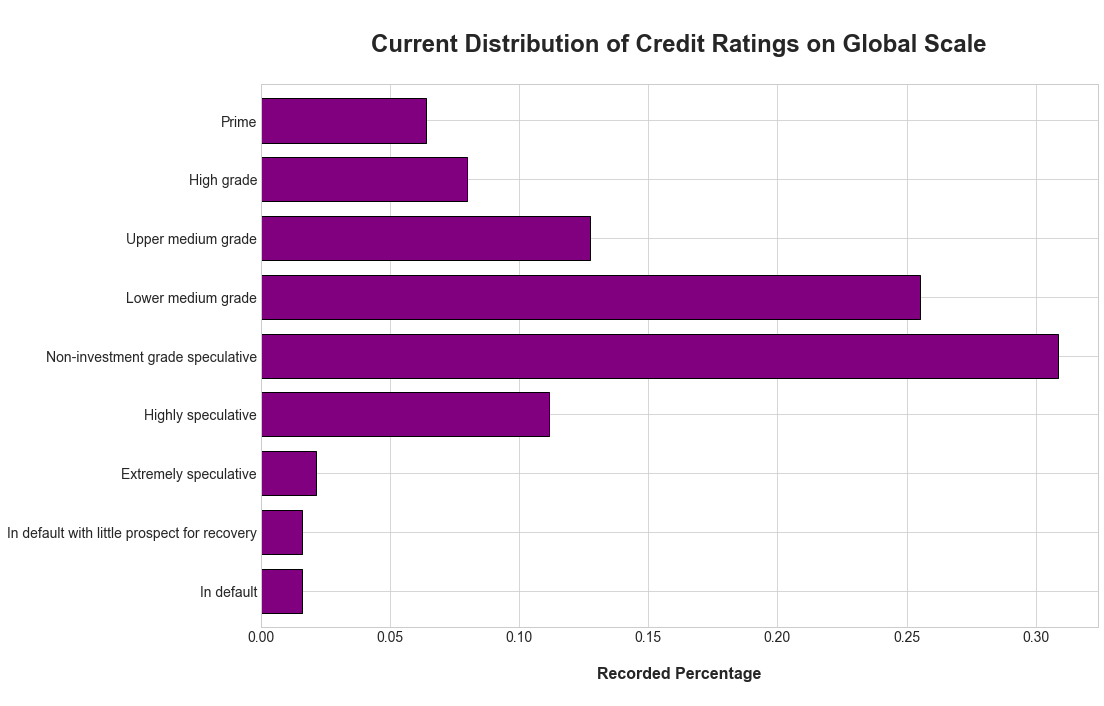

In [313]:
#Plot the distribution by class
ax = tempdf.plot(kind = 'barh', figsize = (15, 10), color = ['purple'], 
                                            edgecolor = 'black', width = .75)

#Format the axis
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
ax.invert_yaxis()

#Format the plot
plt.title('\nCurrent Distribution of Credit Ratings on Global Scale\n', fontsize = 24, fontweight = 'bold')
plt.xlabel('\nRecorded Percentage\n', fontweight = 'bold', fontsize = 16)
plt.show();

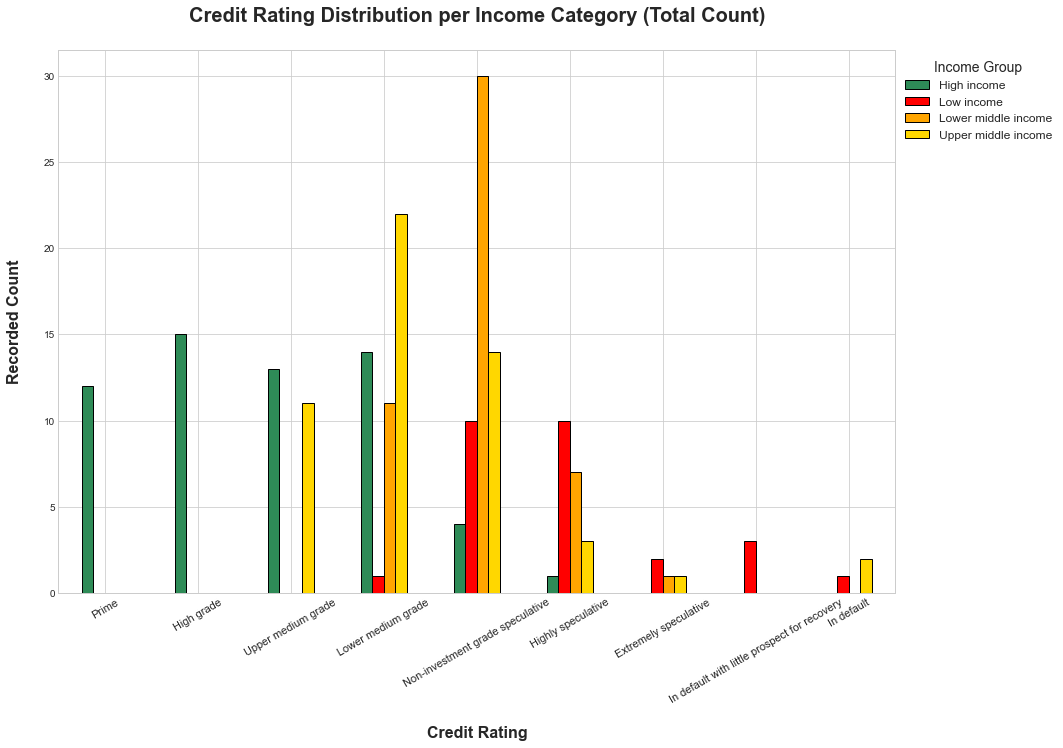

In [343]:
#Use function to create sub-dataframe
income_groups_sub = create_subdf('Income Group', norm = False)

#Plot
income_groups_sub.plot(kind = 'bar', figsize = (15, 10), color = ['seagreen', 'red', 'orange', 'gold'],
                      edgecolor = 'black')


#Format Plot
plt.xticks(rotation = 30, fontsize = 11)
plt.xlabel('\nCredit Rating', fontweight = 'bold', fontsize = 16)
plt.ylabel('Recorded Count\n', fontweight = 'bold', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Income Group', title_fontsize = 14,
          fontsize = 12)
plt.title('Credit Rating Distribution per Income Category (Total Count)\n', fontsize = 20, fontweight = 'bold')


plt.show();

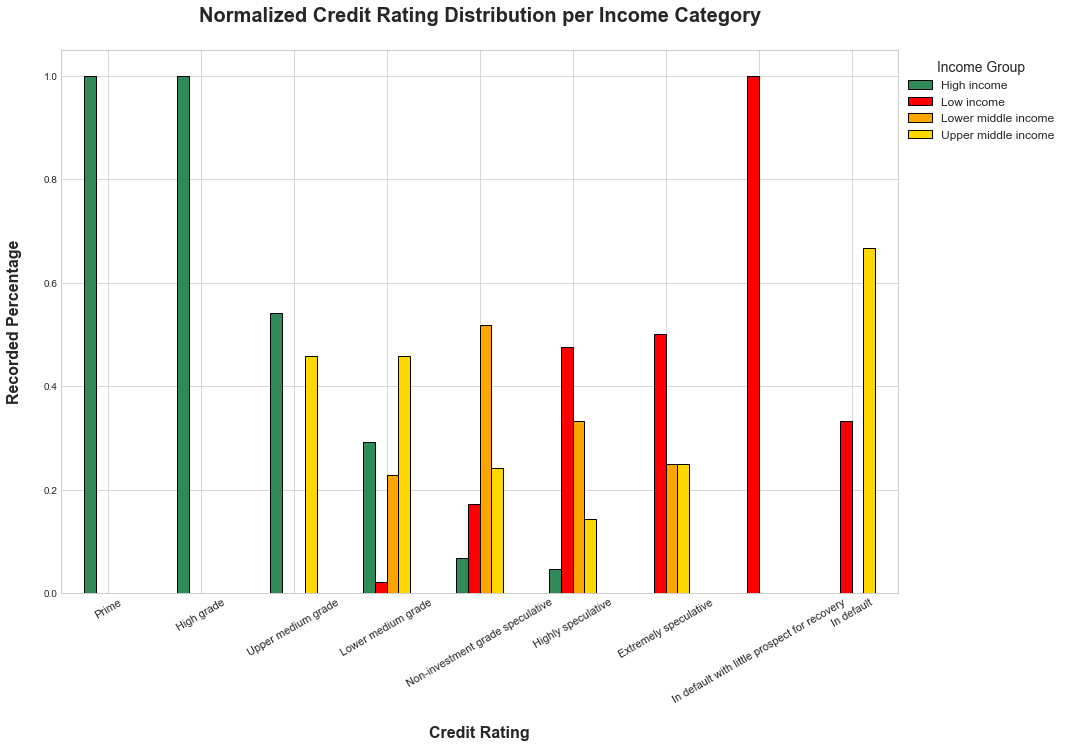

In [339]:
#Use function to create sub-dataframe
income_groups_sub = create_subdf('Income Group')

#Plot
income_groups_sub.plot(kind = 'bar', figsize = (15, 10), color = ['seagreen', 'red', 'orange', 'gold'],
                      edgecolor = 'black')


#Format Plot
plt.xticks(rotation = 30, fontsize = 11)
plt.xlabel('\nCredit Rating', fontweight = 'bold', fontsize = 16)
plt.ylabel('Recorded Percentage\n', fontweight = 'bold', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Income Group', title_fontsize = 14,
          fontsize = 12)
plt.title('Normalized Credit Rating Distribution per Income Category\n', fontsize = 20, fontweight = 'bold')
plt.show();

In [316]:
#Zooming in on the last group on the previous chart
finaldf.loc[(finaldf['Income Group'] == 'Upper middle income') & (finaldf['Credit Rating'] == 'In default')]

,Country Name,Credit Rating,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
LBN,Lebanon,In default,4.081096e+10,13.9476,0.0,17.377,23.11,26.89,28.0,25.0,137.0,149.0,12.0,-3.0,10.0,130.024612,17.0,4.457,143.0,35.358188,2.075,4.276211,2.223272e+09,0.680724,3.539197e+08,3.971004e+10,51992.0,5792.255330,22.0,Upper middle income,80.869,77.140,0.063083,110.0,271.0,339.0,106.0,0.099061,6855713.0,Middle East & North Africa,10450.0,9.77,4.84,6.04,0.285139,26.0
VEN,Venezuela,In default,4.164259e+11,84.6214,0.0,17.566,13.50,16.50,16.0,15.0,173.0,176.0,3.0,-1.0,17.0,2740.273985,34.0,7.118,188.0,208.753268,2.250,4.180160,9.340000e+08,0.592947,1.076000e+09,4.824000e+11,482400.0,14025.357565,10.0,Upper middle income,76.004,68.327,0.300787,1056.0,5322.0,6823.0,806.0,-1.235041,28515829.0,Latin America & Caribbean,912050.0,7.72,6.83,7.16,-1.198769,16.0


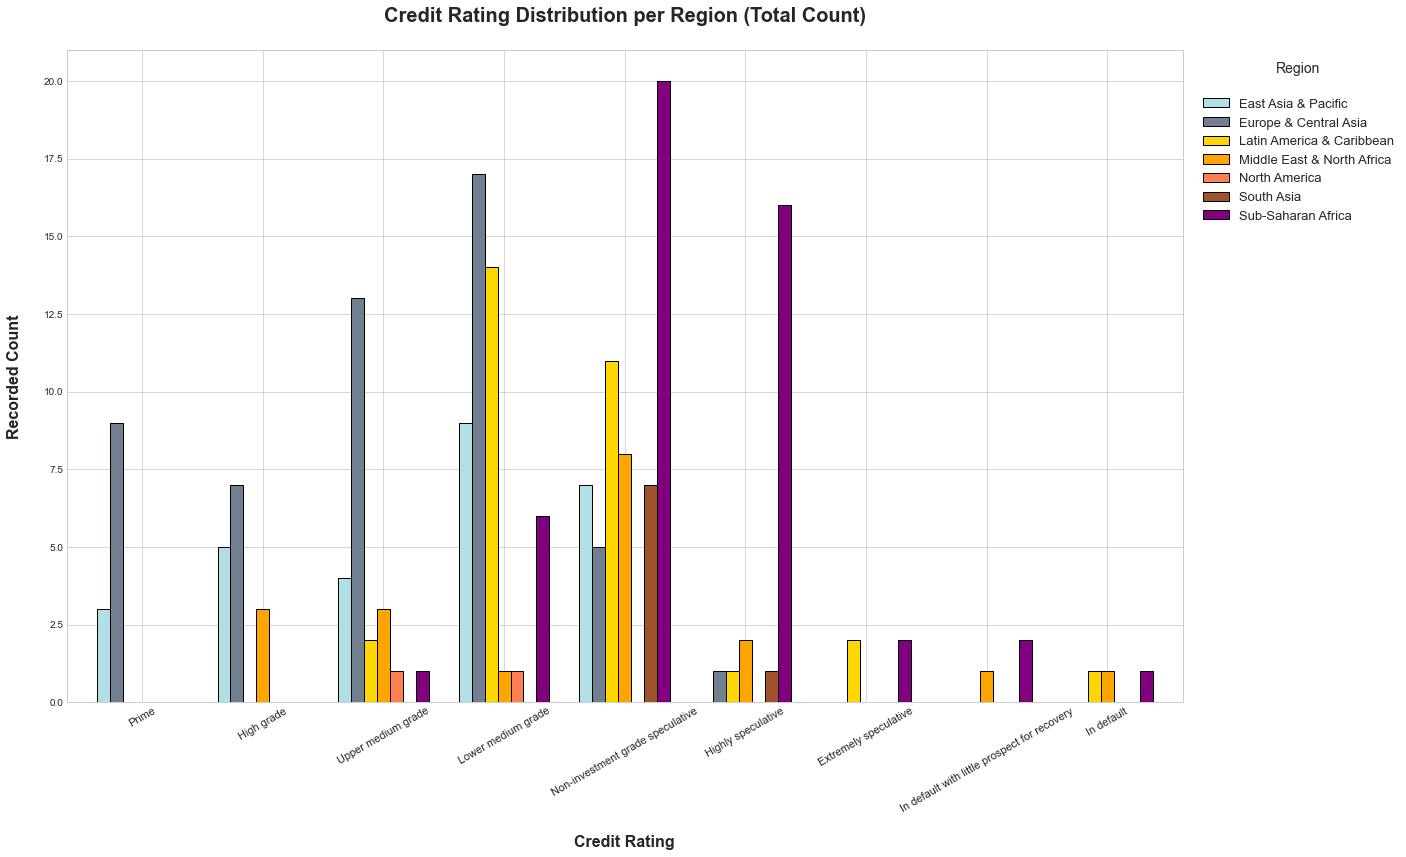

In [433]:
#Use function to create sub-dataframe
region_sub = create_subdf('Region', norm = False)

#Plot
region_sub.plot(kind = 'bar', figsize = (20, 12), color = ['powderblue', 'slategray', 'gold', 'orange', 'coral', 
                                                           'sienna', 'purple'], edgecolor = 'black', width = .75)


#Format Plot
plt.xticks(rotation = 30, fontsize = 11)
plt.xlabel('\nCredit Rating', fontweight = 'bold', fontsize = 16)
plt.ylabel('Recorded Count\n', fontweight = 'bold', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), title = 'Region\n', title_fontsize = 14,
          fontsize = 13)
plt.title('Credit Rating Distribution per Region (Total Count)\n', fontsize = 20, fontweight = 'bold')


plt.show();

In [327]:
finaldf.head()

,Country Name,Credit Rating,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
AFG,Afghanistan,Non-investment grade speculative,1.864930e+10,61.3250,29940.0,31.802,15.000000,23.000000,16.000000,19.000000,173.0,165.0,-8.0,3.0,9.0,149.895975,20.0,6.285,173.0,877.685581,4.321,0.121323,2.340455e+07,0.136441,2.632105e+07,2.180886e+10,19291.0,573.287551,10.0,Low income,66.388000,63.382000,3.063593,1961.0,12368.0,13461.0,2584.0,2.311817,38041754.0,South Asia,652860.0,13.81,10.19,10.98,3.322572,26.0
AGO,Angola,Highly speculative,5.411314e+10,145.3900,25.0,40.232,23.700000,30.300000,26.000000,27.000000,146.0,142.0,-4.0,1.0,6.0,378.883721,30.0,7.981,177.0,40.556871,5.442,-4.614588,-4.098479e+09,-2.645282,-2.349426e+09,9.901351e+10,88816.0,3111.157699,22.0,Lower middle income,64.039000,58.416000,1.451251,5208.0,8736.0,10939.0,10336.0,3.242983,31825295.0,Sub-Saharan Africa,1246700.0,7.22,6.63,6.93,4.249894,31.0
ALB,Albania,Lower medium grade,1.232864e+10,19.5028,0.0,11.620,34.500000,37.500000,35.000000,36.000000,106.0,104.0,-2.0,1.0,9.0,119.049258,15.0,8.082,82.0,31.555552,1.597,7.860513,1.201022e+09,0.261643,3.997687e+07,1.487230e+10,15279.0,5210.688290,35.0,Upper middle income,80.201000,77.002000,0.026286,35.0,70.0,86.0,31.0,-0.426007,2854191.0,Europe & Central Asia,28750.0,11.31,11.58,11.47,1.071414,32.0
AND,Andorra,Lower medium grade,8.617799e+11,39.0078,0.0,7.000,61.225273,68.629273,64.927273,64.927273,29.0,29.0,0.0,0.0,10.0,118.395921,10.0,3.900,93.5,118.395921,1.610,-17.303112,1.668283e+10,2.214117,1.790851e+10,3.539838e+09,3154.0,45887.302126,35.0,High income,74.959033,70.164913,0.714365,0.0,1.0,2.0,0.0,0.176454,77142.0,Europe & Central Asia,470.0,2.90,2.90,2.90,0.088439,77.0
ARE,United Arab Emirates,High grade,3.840381e+11,5.2276,0.0,10.223,65.710000,76.290000,71.000000,71.000000,21.0,21.0,0.0,0.0,6.0,114.524661,0.0,1.521,16.0,92.456253,1.387,3.273826,1.378747e+10,3.775711,1.590111e+10,4.047000e+11,421142.0,41420.483032,47.0,High income,79.314000,77.291000,0.005602,85.0,188.0,426.0,93.0,1.438780,9770529.0,Middle East & North Africa,98647.9,6.33,1.42,2.28,1.746897,72.0


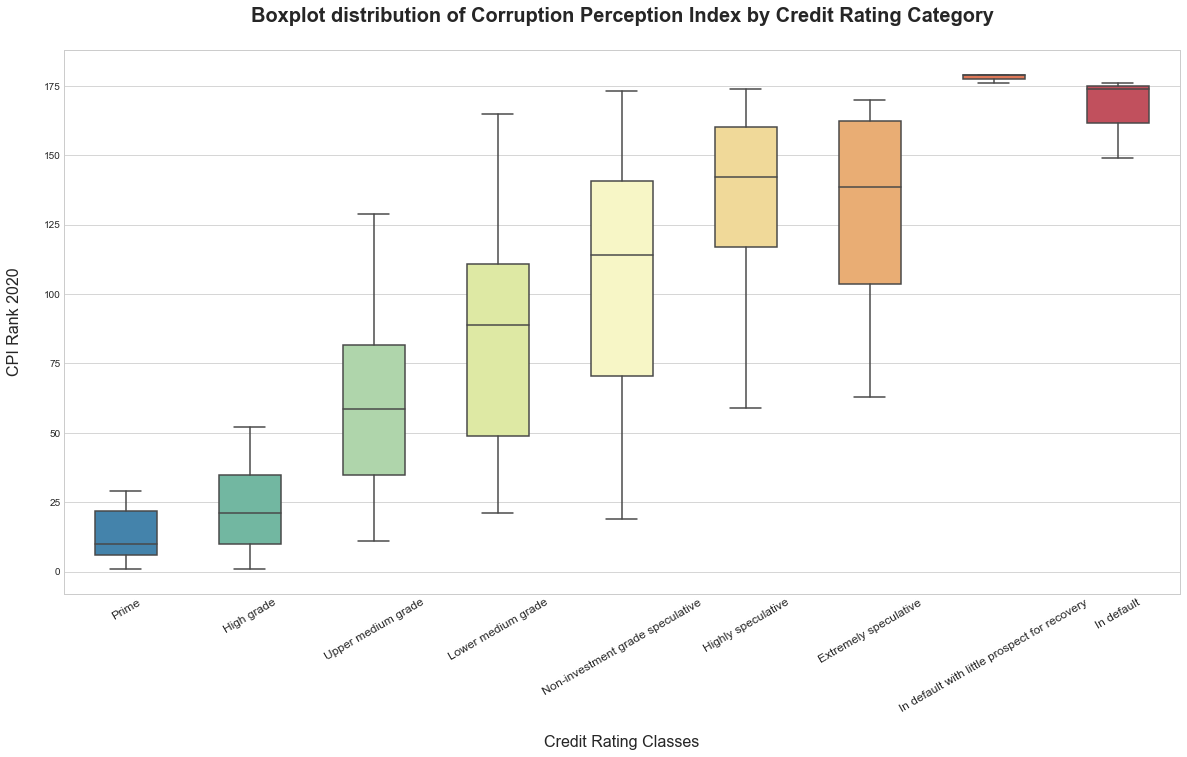

In [319]:
#Plot CPI against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'CPI rank 2020', data = finaldf, order = ordered_ratings, 
            width = .5, palette = 'Spectral_r')

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('CPI Rank 2020\n', fontsize = 16)
plt.title('Boxplot distribution of Corruption Perception Index by Credit Rating Category\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

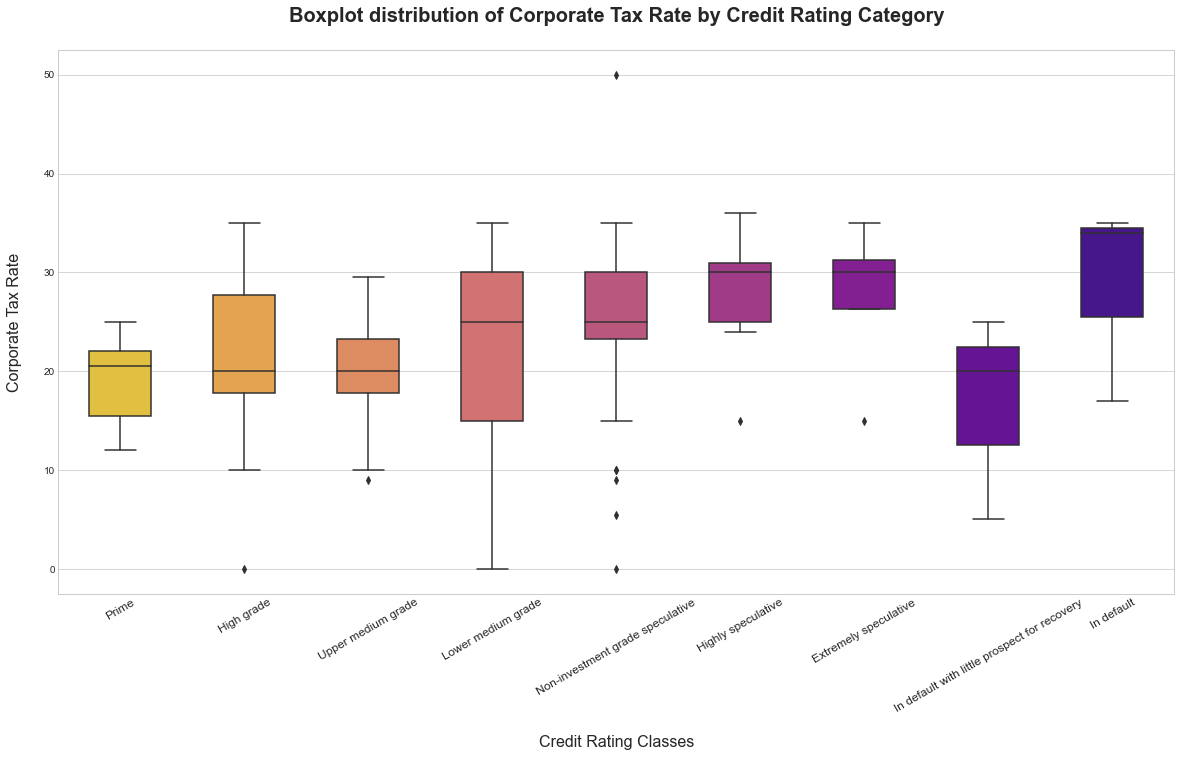

In [366]:
#Plot CPI against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'Corporate Tax Rate', data = finaldf, order = ordered_ratings, 
              palette = 'plasma_r', width = .5)

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('Corporate Tax Rate\n', fontsize = 16)
plt.title('Boxplot distribution of Corporate Tax Rate by Credit Rating Category\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

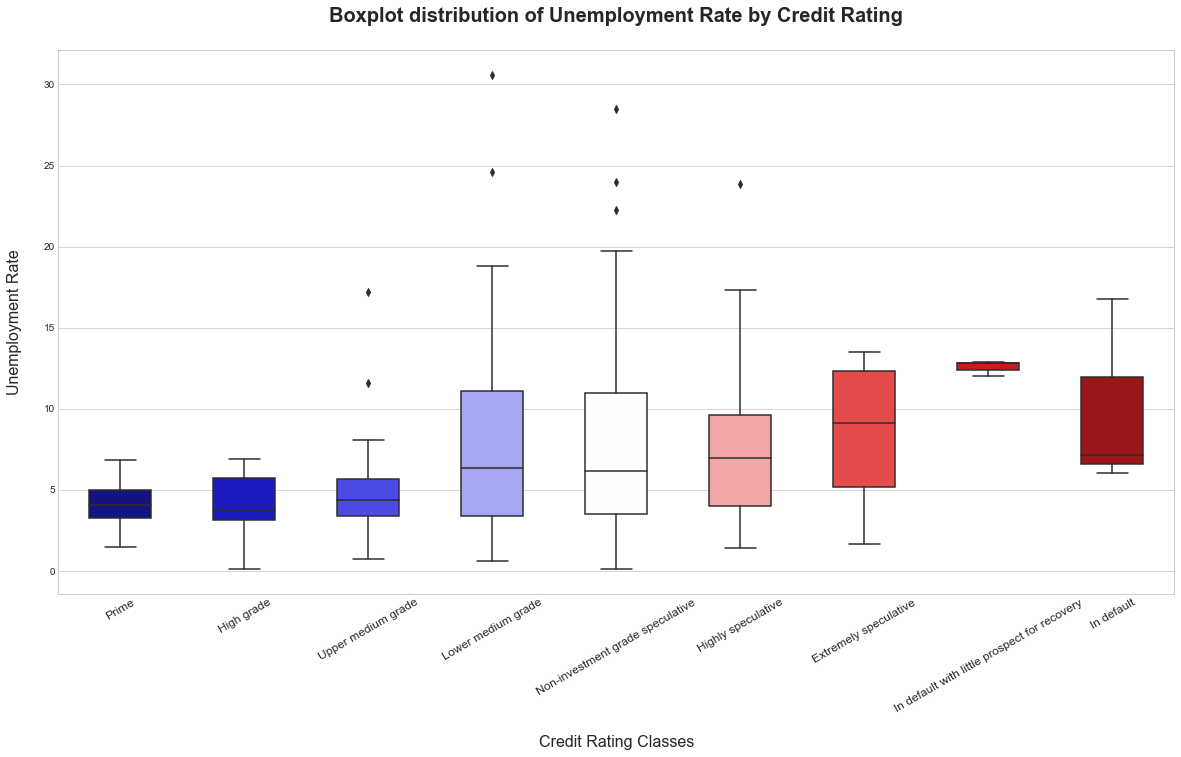

In [367]:
#Plot Unemployment against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 
            data = finaldf, order = ordered_ratings, palette = 'seismic', width = .5)

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('Unemployment Rate\n', fontsize = 16)
plt.title('Boxplot distribution of Unemployment Rate by Credit Rating\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

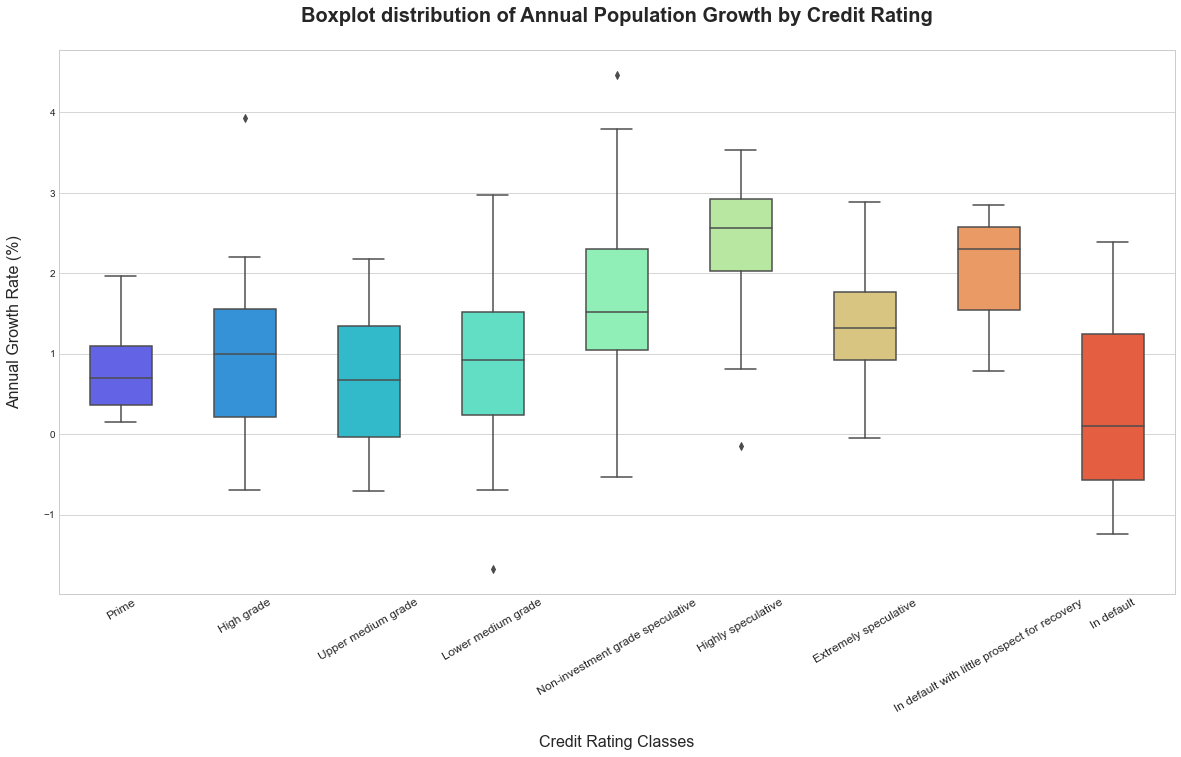

In [368]:
#Plot CPI against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'Population growth (annual %)', 
            data = finaldf, order = ordered_ratings, palette = 'rainbow', width = .5)

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('Annual Growth Rate (%)\n', fontsize = 16)
plt.title('Boxplot distribution of Annual Population Growth by Credit Rating\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

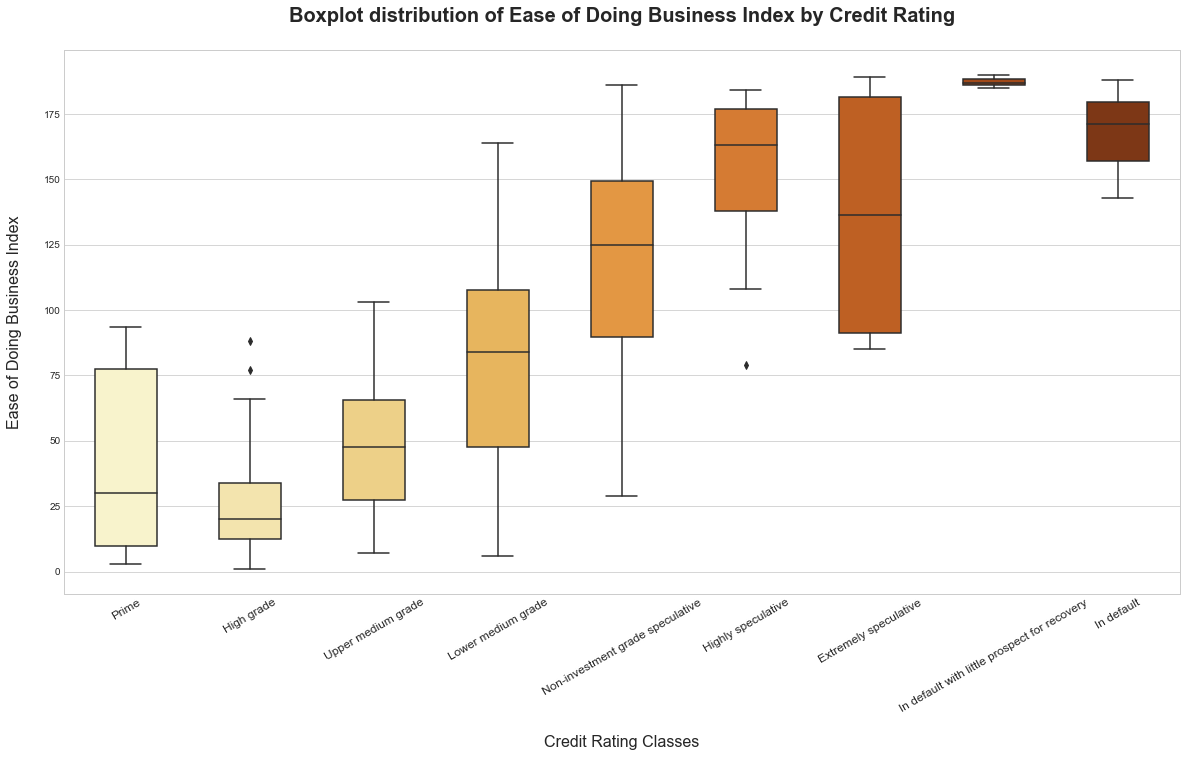

In [372]:
#Plot CPI against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'Ease of doing business index (1=most business-friendly regulations)', 
            data = finaldf, order = ordered_ratings, palette = 'YlOrBr', width = .5)

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('Ease of Doing Business Index\n', fontsize = 16)
plt.title('Boxplot distribution of Ease of Doing Business Index by Credit Rating\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

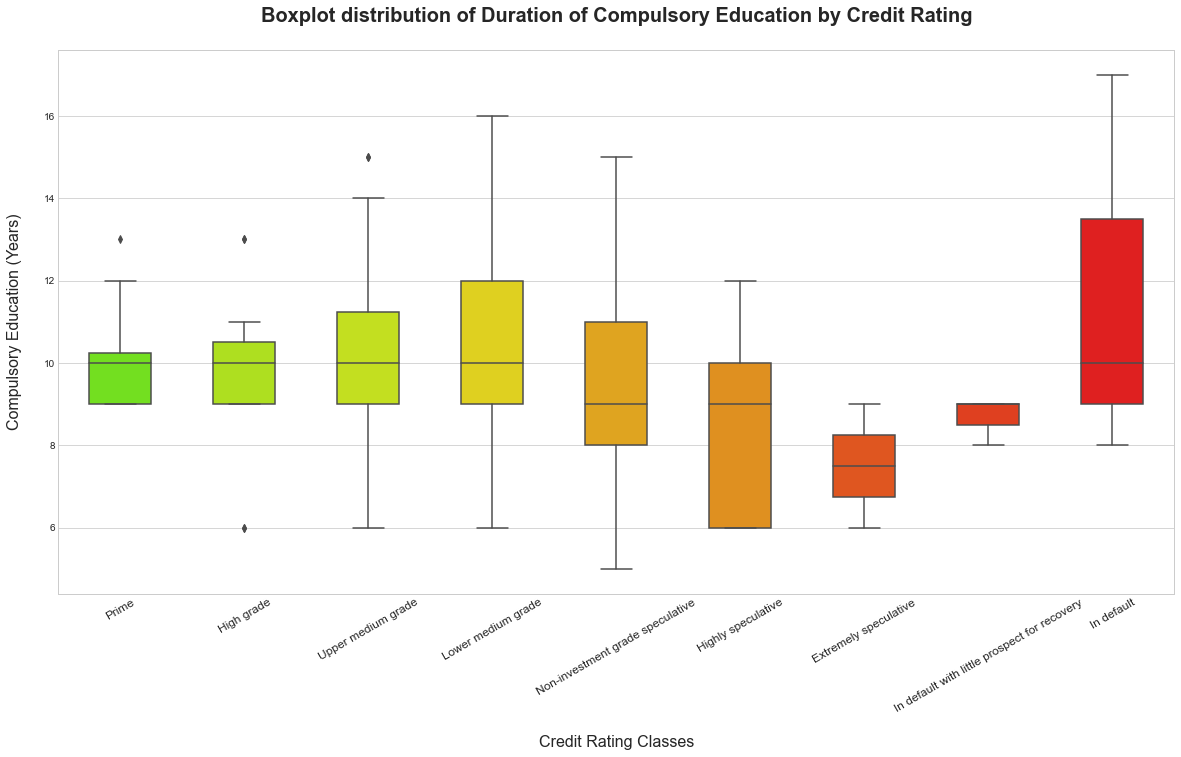

In [392]:
#Plot CPI against Credit Rating
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Credit Rating', y = 'Compulsory education, duration (years)', 
            data = finaldf, order = ordered_ratings, palette = 'prism_r', width = .5)

#Format Plot
plt.xticks(rotation = 30, fontsize = 12)
plt.xlabel('\nCredit Rating Classes', fontsize = 16)
plt.ylabel('Compulsory Education (Years)\n', fontsize = 16)
plt.title('Boxplot distribution of Duration of Compulsory Education by Credit Rating\n', fontsize = 20, 
         fontweight = 'bold')
plt.show();

# Data Modeling Using Support Vector Machines

In [375]:
#Import Cleaned Dataset on Country Credit Ratings
df = pd.read_csv('Credit_Rating_Analysis_DF.csv')
df = df.rename(columns = {'Unnamed: 0' : 'Country Code'})
df.set_index('Country Code', inplace = True)
df.head()

,Country Name,Credit Rating,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,Income Group,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Region,Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Non-investment grade speculative,1.864930e+10,61.3250,29940.0,31.802,15.000000,23.000000,16.000000,19.000000,173.0,165.0,-8.0,3.0,9.0,149.895975,20.0,6.285,173.0,877.685581,4.321,0.121323,2.340455e+07,0.136441,2.632105e+07,2.180886e+10,19291.0,573.287551,10.0,Low income,66.388000,63.382000,3.063593,1961.0,12368.0,13461.0,2584.0,2.311817,38041754.0,South Asia,652860.0,13.81,10.19,10.98,3.322572,26.0
AGO,Angola,Highly speculative,5.411314e+10,145.3900,25.0,40.232,23.700000,30.300000,26.000000,27.000000,146.0,142.0,-4.0,1.0,6.0,378.883721,30.0,7.981,177.0,40.556871,5.442,-4.614588,-4.098479e+09,-2.645282,-2.349426e+09,9.901351e+10,88816.0,3111.157699,22.0,Lower middle income,64.039000,58.416000,1.451251,5208.0,8736.0,10939.0,10336.0,3.242983,31825295.0,Sub-Saharan Africa,1246700.0,7.22,6.63,6.93,4.249894,31.0
ALB,Albania,Lower medium grade,1.232864e+10,19.5028,0.0,11.620,34.500000,37.500000,35.000000,36.000000,106.0,104.0,-2.0,1.0,9.0,119.049258,15.0,8.082,82.0,31.555552,1.597,7.860513,1.201022e+09,0.261643,3.997687e+07,1.487230e+10,15279.0,5210.688290,35.0,Upper middle income,80.201000,77.002000,0.026286,35.0,70.0,86.0,31.0,-0.426007,2854191.0,Europe & Central Asia,28750.0,11.31,11.58,11.47,1.071414,32.0
AND,Andorra,Lower medium grade,8.617799e+11,39.0078,0.0,7.000,61.225273,68.629273,64.927273,64.927273,29.0,29.0,0.0,0.0,10.0,118.395921,10.0,3.900,93.5,118.395921,1.610,-17.303112,1.668283e+10,2.214117,1.790851e+10,3.539838e+09,3154.0,45887.302126,35.0,High income,74.959033,70.164913,0.714365,0.0,1.0,2.0,0.0,0.176454,77142.0,Europe & Central Asia,470.0,2.90,2.90,2.90,0.088439,77.0
ARE,United Arab Emirates,High grade,3.840381e+11,5.2276,0.0,10.223,65.710000,76.290000,71.000000,71.000000,21.0,21.0,0.0,0.0,6.0,114.524661,0.0,1.521,16.0,92.456253,1.387,3.273826,1.378747e+10,3.775711,1.590111e+10,4.047000e+11,421142.0,41420.483032,47.0,High income,79.314000,77.291000,0.005602,85.0,188.0,426.0,93.0,1.438780,9770529.0,Middle East & North Africa,98647.9,6.33,1.42,2.28,1.746897,72.0


In [376]:
#Verify Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, AFG to ZWE
Data columns (total 46 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Country Name                                                           188 non-null    object 
 1   Credit Rating                                                          188 non-null    object 
 2   Adjusted net national income (current US$)                             188 non-null    float64
 3   Adolescent fertility rate (births per 1,000 women ages 15-19)          188 non-null    float64
 4   Battle-related deaths (number of people)                               188 non-null    float64
 5   Birth rate, crude (per 1,000 people)                                   188 non-null    float64
 6   CI Lower                                                               188 non-null    float6

In [377]:
#Define DataFrame for modeling and target variable y
X = df.drop(['Country Name', 'Credit Rating'], axis = 1)
y = df['Credit Rating']

In [378]:
#Define categorical variables
cat_feats = ['Income Group', 'Region']

#Create dummy variable
dummy = pd.get_dummies(df[cat_feats], drop_first = True)
dummy.shape

(188, 9)

In [379]:
#Finalize X for modeling
X.drop(cat_feats, axis = 1, inplace = True)

X = pd.concat([X, dummy], axis = 1)
display(X.head())
display(X.info())

,Adjusted net national income (current US$),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Battle-related deaths (number of people),"Birth rate, crude (per 1,000 people)",CI Lower,CI Upper,CPI 2019,CPI 2020,CPI rank 2019,CPI rank 2020,Change in rank 2019-2020,Change in scores 2019-2020,"Compulsory education, duration (years)",Consumer price index (2010 = 100),Corporate Tax Rate,"Death rate, crude (per 1,000 people)",Ease of doing business index (1=most business-friendly regulations),Exports of goods and services (% of GDP),"Fertility rate, total (births per woman)","Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)","Foreign direct investment, net outflows (% of GDP)","Foreign direct investment, net outflows (BoP, current US$)",GDP (constant 2010 US$),GDP (million of US dollars),GDP per capita (constant 2010 US$),Global Insight Country Risk Ratings,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Lifetime risk of maternal death (%),Number of deaths ages 10-14 years,Number of deaths ages 15-19 years,Number of deaths ages 20-24 years,Number of deaths ages 5-9 years,Population growth (annual %),"Population, total",Surface area (sq. km),"Unemployment, female (% of female labor force) (modeled ILO estimate)","Unemployment, male (% of male labor force) (modeled ILO estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),Varieties of Democracy Project,Income Group_Low income,Income Group_Lower middle income,Income Group_Upper middle income,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_North America,Region_South Asia,Region_Sub-Saharan Africa
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFG,1.864930e+10,61.3250,29940.0,31.802,15.000000,23.000000,16.000000,19.000000,173.0,165.0,-8.0,3.0,9.0,149.895975,20.0,6.285,173.0,877.685581,4.321,0.121323,2.340455e+07,0.136441,2.632105e+07,2.180886e+10,19291.0,573.287551,10.0,66.388000,63.382000,3.063593,1961.0,12368.0,13461.0,2584.0,2.311817,38041754.0,652860.0,13.81,10.19,10.98,3.322572,26.0,1,0,0,0,0,0,0,1,0
AGO,5.411314e+10,145.3900,25.0,40.232,23.700000,30.300000,26.000000,27.000000,146.0,142.0,-4.0,1.0,6.0,378.883721,30.0,7.981,177.0,40.556871,5.442,-4.614588,-4.098479e+09,-2.645282,-2.349426e+09,9.901351e+10,88816.0,3111.157699,22.0,64.039000,58.416000,1.451251,5208.0,8736.0,10939.0,10336.0,3.242983,31825295.0,1246700.0,7.22,6.63,6.93,4.249894,31.0,0,1,0,0,0,0,0,0,1
ALB,1.232864e+10,19.5028,0.0,11.620,34.500000,37.500000,35.000000,36.000000,106.0,104.0,-2.0,1.0,9.0,119.049258,15.0,8.082,82.0,31.555552,1.597,7.860513,1.201022e+09,0.261643,3.997687e+07,1.487230e+10,15279.0,5210.688290,35.0,80.201000,77.002000,0.026286,35.0,70.0,86.0,31.0,-0.426007,2854191.0,28750.0,11.31,11.58,11.47,1.071414,32.0,0,0,1,1,0,0,0,0,0
AND,8.617799e+11,39.0078,0.0,7.000,61.225273,68.629273,64.927273,64.927273,29.0,29.0,0.0,0.0,10.0,118.395921,10.0,3.900,93.5,118.395921,1.610,-17.303112,1.668283e+10,2.214117,1.790851e+10,3.539838e+09,3154.0,45887.302126,35.0,74.959033,70.164913,0.714365,0.0,1.0,2.0,0.0,0.176454,77142.0,470.0,2.90,2.90,2.90,0.088439,77.0,0,0,0,1,0,0,0,0,0
ARE,3.840381e+11,5.2276,0.0,10.223,65.710000,76.290000,71.000000,71.000000,21.0,21.0,0.0,0.0,6.0,114.524661,0.0,1.521,16.0,92.456253,1.387,3.273826,1.378747e+10,3.775711,1.590111e+10,4.047000e+11,421142.0,41420.483032,47.0,79.314000,77.291000,0.005602,85.0,188.0,426.0,93.0,1.438780,9770529.0,98647.9,6.33,1.42,2.28,1.746897,72.0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, AFG to ZWE
Data columns (total 51 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Adjusted net national income (current US$)                             188 non-null    float64
 1   Adolescent fertility rate (births per 1,000 women ages 15-19)          188 non-null    float64
 2   Battle-related deaths (number of people)                               188 non-null    float64
 3   Birth rate, crude (per 1,000 people)                                   188 non-null    float64
 4   CI Lower                                                               188 non-null    float64
 5   CI Upper                                                               188 non-null    float64
 6   CPI 2019                                                               188 non-null    float6

None

In [380]:
#Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

## RBF Kernel

In [381]:
#Use GridSearch to determine best parameters
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma': [1, 0.1, 0.001, 0.001, 0.0001], 
             'kernel': ['rbf']}

#Instantial GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

#Fit to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.300, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

C:\Users\u-ana\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.300, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.300, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.333, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.001, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [382]:
#Check best params
print(grid_search.best_params_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [422]:
#Instantiate and train model with the determined params
model = SVC(kernel = 'rbf', gamma = 1, C = .1)
model.fit(X_train, y_train)

#Predict train and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [423]:
accuracy_comp(y_train, train_pred, y_test, test_pred)
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 32.67%
Test Accuracy: 23.68%

 Classification Report: 
                                               precision    recall  f1-score   support

                                  High grade       0.00      0.00      0.00         4
                          Highly speculative       0.00      0.00      0.00         3
                                  In default       0.00      0.00      0.00         2
In default with little prospect for recovery       0.00      0.00      0.00         1
                          Lower medium grade       0.00      0.00      0.00         9
            Non-investment grade speculative       0.24      1.00      0.38         9
                                       Prime       0.00      0.00      0.00         3
                          Upper medium grade       0.00      0.00      0.00         7

                                    accuracy                           0.24        38
                                   macro avg       0.03      0.

C:\Users\u-ana\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Polynomial Kernel

In [430]:
#Instantiate and train model with the determined params
model2 = SVC(kernel = 'poly', gamma = 1, C = 0.1, degree = 5)
model2.fit(X_train, y_train)

#Predict train and test sets
train_pred = model2.predict(X_train)
test_pred = model2.predict(X_test)

In [431]:
accuracy_comp(y_train, train_pred, y_test, test_pred)
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 11.33%
Test Accuracy: 18.42%

 Classification Report: 
                                               precision    recall  f1-score   support

                                  High grade       0.00      0.00      0.00         4
                          Highly speculative       0.00      0.00      0.00         3
                                  In default       0.00      0.00      0.00         2
In default with little prospect for recovery       0.00      0.00      0.00         1
                          Lower medium grade       0.00      0.00      0.00         9
            Non-investment grade speculative       0.00      0.00      0.00         9
                                       Prime       0.00      0.00      0.00         3
                          Upper medium grade       0.18      1.00      0.31         7

                                    accuracy                           0.18        38
                                   macro avg       0.02      0.

C:\Users\u-ana\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
